# Abstract

The identification of linear B-cell epitopes is a critical component in the development of vaccines, diagnostic tests, and therapeutic interventions against infectious diseases, allergies, and certain cancers. Experimental discovery of epitopes is often laborious and resource-intensive, making computational methods a valuable alternative for prioritizing candidates. In this report, I present a data mining pipeline using Python to predict potential epitopes for Alphavirus, a genus of mosquito-borne viruses responsible for widespread infections. I explore the trade-off between using smaller amounts of data from viruses similar to the target genus and using larger volumes of data from more distant relatives. Utilizing the second and third datasets of five provided training datasets, which include data from closer relatives, I aim to develop an efficient pipeline to potentially predict new, previously unknown epitopes in the Alphavirus genus

# Introduction

Linear B-cell epitopes are essential in various aspects of medical research and treatment, including vaccine development, diagnostic tests, and therapeutic interventions. The experimental discovery of these epitopes is often time-consuming and requires significant resources, making computational methods an attractive option for prioritizing epitope candidates. Over the past three decades, computational techniques have significantly improved the efficiency of epitope identification, especially in recent advancements.

The focus of this coursework is the Alphavirus genus, a group of mosquito-borne viruses that include medically significant pathogens such as Chikungunya. These viruses affect millions of individuals, predominantly in the Global South, with the potential to spread further due to climate change. The datasets utilized in this study were created by parsing and consolidating data from online databases IEDB, Genbank, and UniProtKB, using research tools developed by the team at Aston University. My primary objective is to develop an efficient data mining pipeline using Python to potentially predict new, previously unknown epitopes in the Alphavirus genus.

To explore the optimal trade-off between using smaller amounts of data from viruses more similar to the target genus and larger volumes of data from more distant relatives, I have been provided with five different training datasets. For this coursework, I will be using only the second and the third dataset, which include data from closer relatives. Each dataset includes 13 information columns, 1293 feature columns, and 1 class column containing the target class. The information columns offer background information on the origin of the observations, while the feature columns contain features calculated for each observation using the state-of-the-art feature embedder for protein data, ESM-1b.

This report outlines the development and evaluation of the data mining pipeline and its effectiveness in predicting potential epitopes for the Alphavirus genus using the first three datasets.

# Data Mining Pipeline for Dataset 2

In this subsection, I will be duscussing the development and evaluation of the data mining pipeline for Dataset 2. 

## Importing required libraries

In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from boruta import BorutaPy
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV, learning_curve
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

## Importing the Dataset 1.

In [232]:
dataset_1 = pd.read_csv('df_training_level2(1).csv')

## Exploratory Data Analysis (EDA)

Quick inspection of the first few rows of the dataset to provide an overview of the data structure, column names, and values and gain an initial understanding of the dataset before proceeding with further exploratory data analysis.

In [233]:
dataset_1.head()

Info_PepID  Info_organism_id Info_protein_id  Info_pos Info_AA  \
0  BAA01867.1:2           1678143      BAA01867.1       262       E   
1  BAA01867.1:2           1678143      BAA01867.1       263       T   
2  BAA01867.1:2           1678143      BAA01867.1       264       S   
3  BAA01867.1:2           1678143      BAA01867.1       265       G   
4  BAA01867.1:2           1678143      BAA01867.1       266       V   

  Info_pubmed_id Info_epitope_id Info_host_id Info_nPos Info_nNeg  ...  \
0       10449466           14543         9606         1         1  ...   
1       10449466           14543         9606         1         1  ...   
2       10449466           14543         9606         1         1  ...   
3       10449466           14543         9606         1         1  ...   
4       10449466           14543         9606         1         1  ...   

  feat_esm1b_1270 feat_esm1b_1271  feat_esm1b_1272  feat_esm1b_1273  \
0       -0.070886       -0.017200        -0.117530        -0.007250   
1        0.220630       -0.210780        -0.021335         0.323588   
2        0.107350       -0.059491        -0.167905         0.257423   
3        0.253621       -0.267090        -0.109026         0.091992   
4        0.027382        0.018629        -0.157104         0.305302   

   feat_esm1b_1274  feat_esm1b_1275  feat_esm1b_1276  feat_esm1b_1277  \
0        -1.071874        -0.519040        -0.308719        -0.281276   
1        -0.736865        -0.343829        -0.507386        -0.020137   
2        -0.930690        -0.271957        -0.133815         0.044392   
3        -0.813677        -0.187964        -0.142268         0.091157   
4        -1.121274        -0.048636        -0.246171         0.147852   

   feat_esm1b_1278  feat_esm1b_1279  
0        -0.256712         0.405690  
1        -0.166644         0.751316  
2        -0.299376         0.461547  
3        -0.436975         0.369129  
4        -0.299121         0.225209  

[5 rows x 1294 columns]

Checking the shape of the dataset to see how many rows and columns are present.

In [234]:
dataset_1.shape

(4946, 1294)

### Investigating feature types

In [235]:
dataset_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4946 entries, 0 to 4945
Columns: 1294 entries, Info_PepID to feat_esm1b_1279
dtypes: float64(1280), int64(4), object(10)
memory usage: 48.8+ MB


### Checking for missing values

Assessing the dataset for any missing values that may be present, as these could potentially impact the performance and accuracy of the data mining pipeline.

In [236]:
dataset_1.isna().sum()

Info_PepID            0
Info_organism_id      0
Info_protein_id       0
Info_pos              0
Info_AA               0
                   ... 
feat_esm1b_1275     521
feat_esm1b_1276     521
feat_esm1b_1277     521
feat_esm1b_1278     521
feat_esm1b_1279     521
Length: 1294, dtype: int64

In [237]:
missing_values_count = dataset_1.isna().sum().sum()
print(f"Total missing values count: {missing_values_count}")

Total missing values count: 666880


### Checking for outliers

In the outlier detection process, the primary goal is to identify and potentially handle any extreme values in the continuous feature variables that may negatively affect the model's performance.

> To achieve this, I first remove the 'Class' column, which represents the target variable, as well as any 'Info_' columns that contain non-predictive information about the observations. This ensures that the analysis focuses solely on the continuous feature variables.

With the filtered dataset containing only the continuous features, various outlier detection techniques can be employed.
Using the **Z-score** for outlier detection is a widely adopted method in continuous feature variables. It measures how many standard deviations an observation is from the mean of the dataset. Observations with a high absolute Z-score are considered outliers, as they deviate significantly from the mean. By applying the Z-score method to the filtered dataset containing only the continuous features, I can effectively identify the presence of any extreme values.

Once the outliers are detected, I can decide whether to remove, transform, or retain them based on the potential impact on model performance. Proper handling of outliers can lead to improved model accuracy and generalization to unseen data.

In [238]:
filtered_data = dataset_1.drop(columns=['Class']).filter(regex='^(?!Info_)')

In [239]:
z_scores = np.abs((filtered_data - filtered_data.mean())/filtered_data.std())
threshold = 3
outliers = z_scores > threshold

outlier_indices = np.where(outliers)
# Create a DataFrame with row indices, column indices, and feature names
outlier_info = pd.DataFrame({'Row': outlier_indices[0],
                             'Column': outlier_indices[1],
                             'Feature': filtered_data.columns[outlier_indices[1]]})

# Print the DataFrame
print("Outlier Indices (Row, Column, Feature):")
outlier_info

Outlier Indices (Row, Column, Feature):


Row  Column          Feature
0         0     493   feat_esm1b_493
1         0     595   feat_esm1b_595
2         0     703   feat_esm1b_703
3         1     129   feat_esm1b_129
4         1     539   feat_esm1b_539
...     ...     ...              ...
40952  4937    1190  feat_esm1b_1190
40953  4938     140   feat_esm1b_140
40954  4939     410   feat_esm1b_410
40955  4940       9     feat_esm1b_9
40956  4940     750   feat_esm1b_750

[40957 rows x 3 columns]

In [240]:
# count total number of True values
n_outliers = outliers.sum().sum()  
print("Total number of outlier records:", n_outliers)

Total number of outlier records: 40957


### Visualizing the dataset

As the dataset has a large number of features, I will be visualizing the dataset using random subsets of features to prevent the cluttering of plots. Executing the cells multiple times can can generate and analyze different random subsets of features, providing a more comprehensive understanding of the dataset and its various feature relationships, as the plots are generated randomly each time the cells are run.

#### Histograms

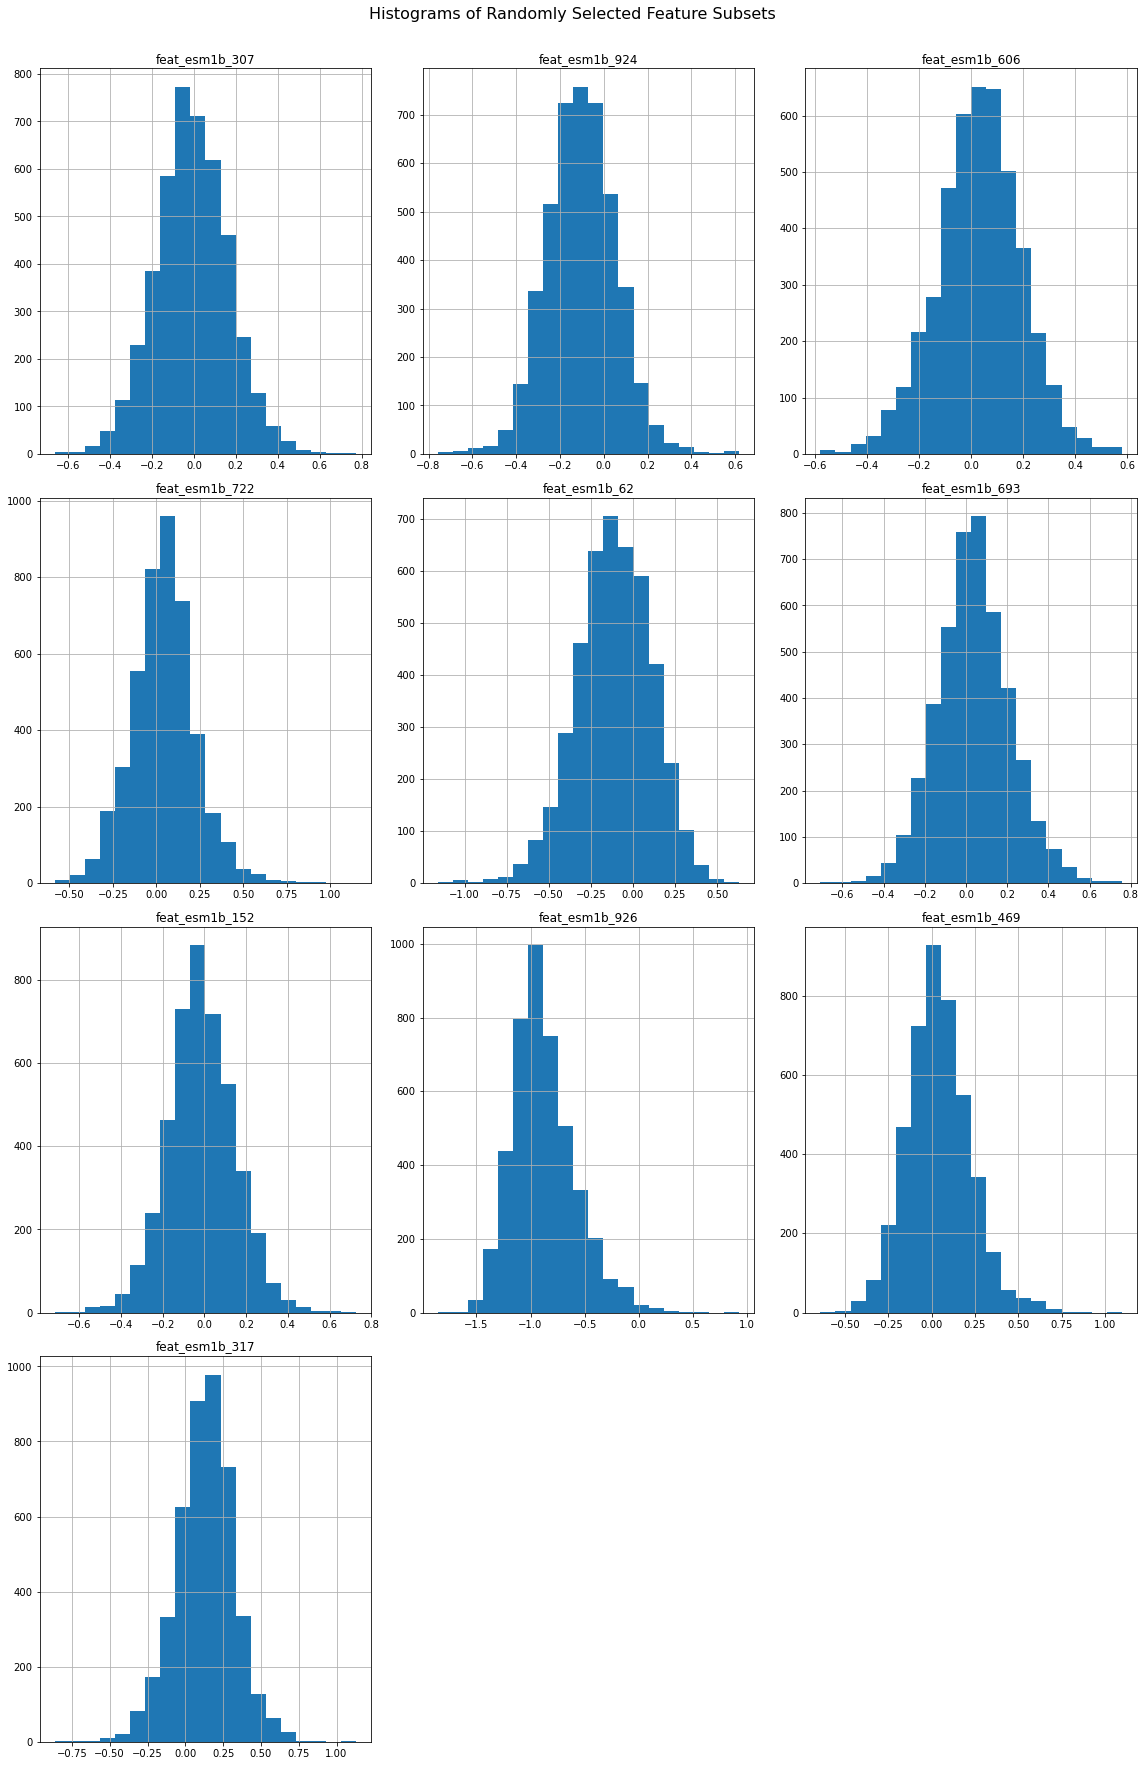

In [241]:
n_subsets = 6
features_per_subset = 10

# Create a list of feature indices
feature_indices = list(range(dataset_1.shape[1]))

# Randomly shuffle the feature indices
random.shuffle(feature_indices)

# Initialize the subplots
fig, axes = plt.subplots(n_subsets, figsize=(16, n_subsets * 4))

# Loop through each subset
for i in range(n_subsets):
    # Select a subset of features
    subset_indices = feature_indices[i * features_per_subset: (i + 1) * features_per_subset]
    subset_features = dataset_1.iloc[:, subset_indices]
    
    # Plot the histograms
    subset_features.hist(ax=axes[i], bins=20)
    axes[i].set_title(f"Histograms of Subset {i + 1} Feature Variables")
    
# Adjust the layout and add a title
plt.tight_layout()
plt.suptitle("Histograms of Randomly Selected Feature Subsets", y=1.02, fontsize=16)
plt.show()

Histograms were plotted for six randomly selected subsets of features, showcasing the distribution of each feature's values. These plots provide insights into the overall shape and spread of the data, helping identify skewness, kurtosis, and potential outliers. By examining the histograms, we can determine if any features exhibit unusual or unexpected patterns that may require further investigation or preprocessing.

#### Box plots

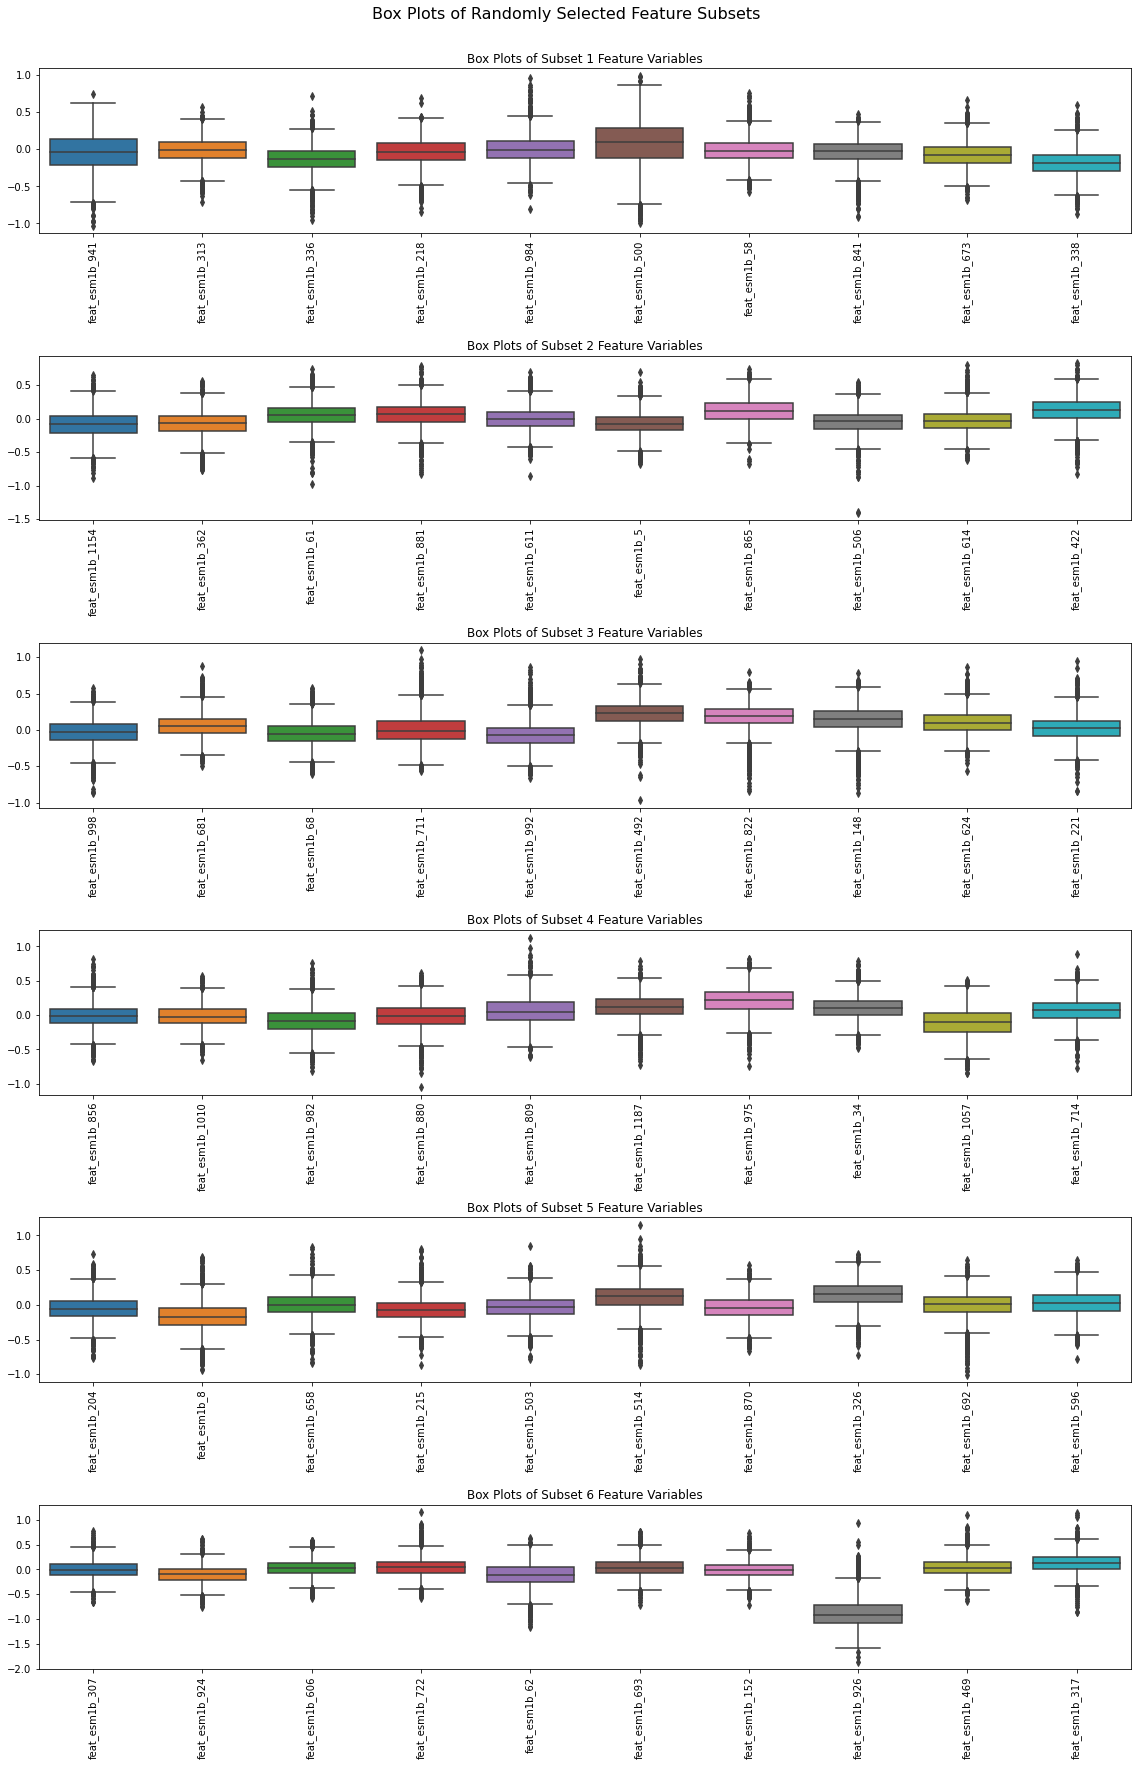

In [242]:
# Initialize the subplots
fig, axes = plt.subplots(n_subsets, figsize=(16, n_subsets * 4))

# Loop through each subset
for i in range(n_subsets):
    # Select a subset of features
    subset_indices = feature_indices[i * features_per_subset: (i + 1) * features_per_subset]
    subset_features = dataset_1.iloc[:, subset_indices]
    
    # Plot the box plots
    sns.boxplot(data=subset_features, ax=axes[i])
    axes[i].set_title(f"Box Plots of Subset {i + 1} Feature Variables")
    axes[i].tick_params(axis='x', rotation=90)

# Adjust the layout and add a title
plt.tight_layout()
plt.suptitle("Box Plots of Randomly Selected Feature Subsets", y=1.02, fontsize=16)
plt.show()

Box plots were also generated for the same six random subsets of features, displaying each feature's median, quartiles, and potential outliers. Box plots provide a more concise visualization of the distribution and spread of each feature, making it easier to identify and compare outliers and variability across different features. By examining these box plots, we can gain a better understanding of the presence of outliers and the overall distribution patterns of the dataset's features.

#### Pair plots

Since pair plots involve pairwise scatter plots for all features in a subset, it's better to choose a smaller number of features per subset (e.g., 4) to avoid cluttered plots.

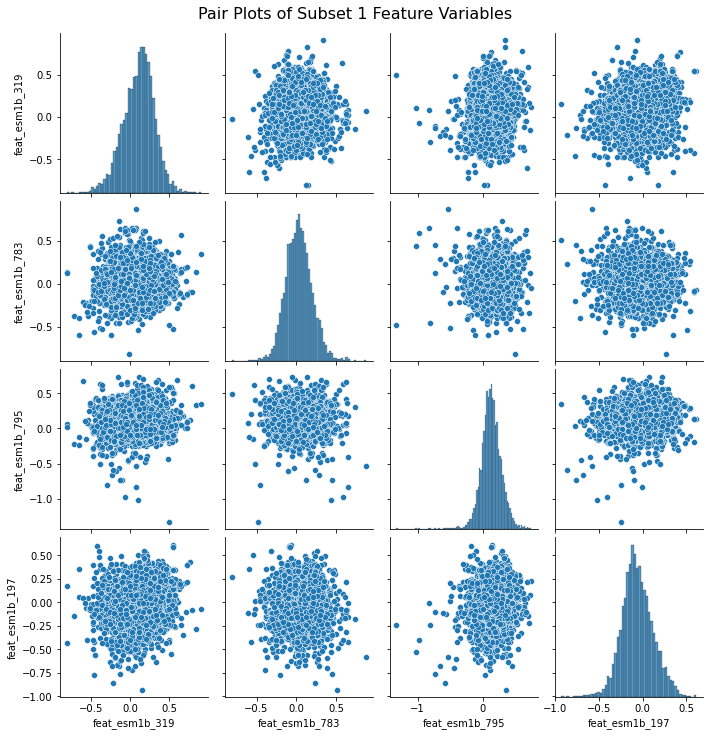

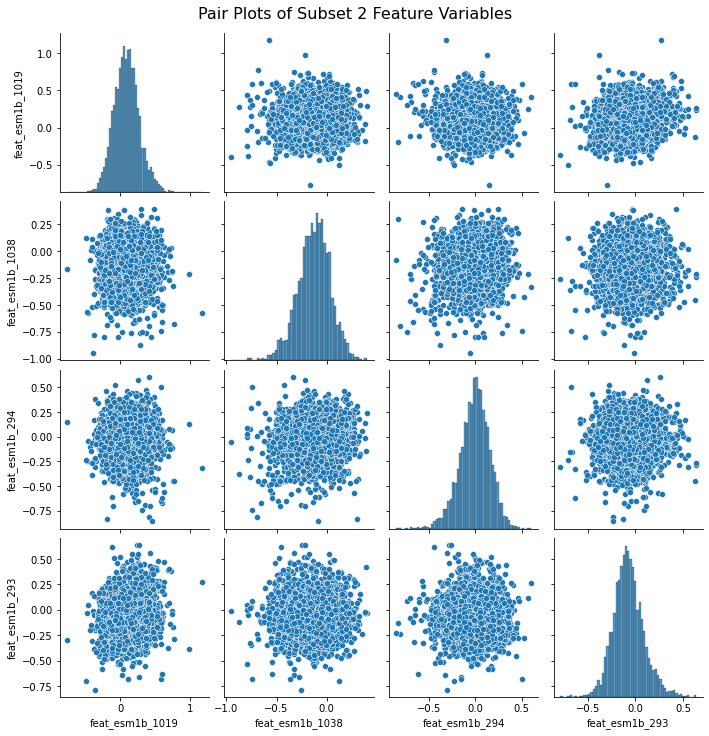

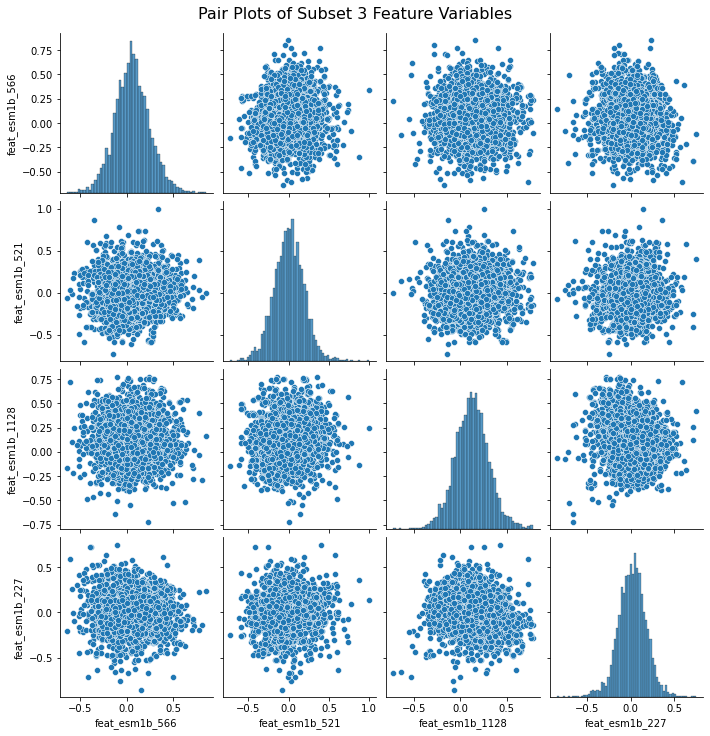

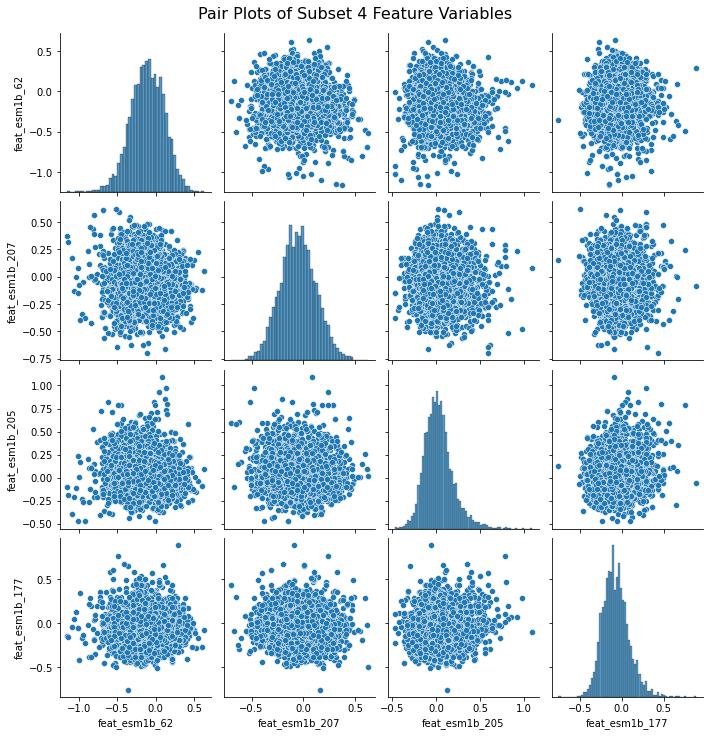

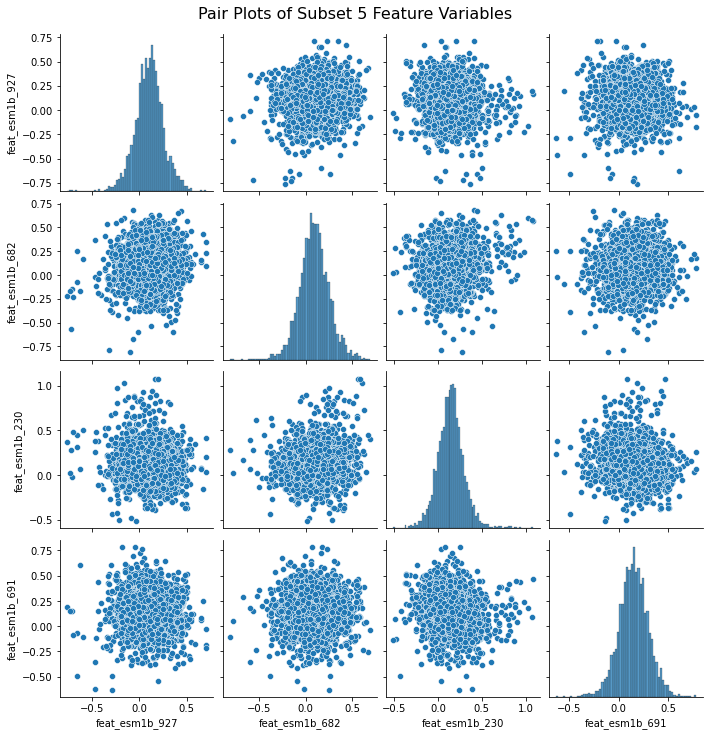

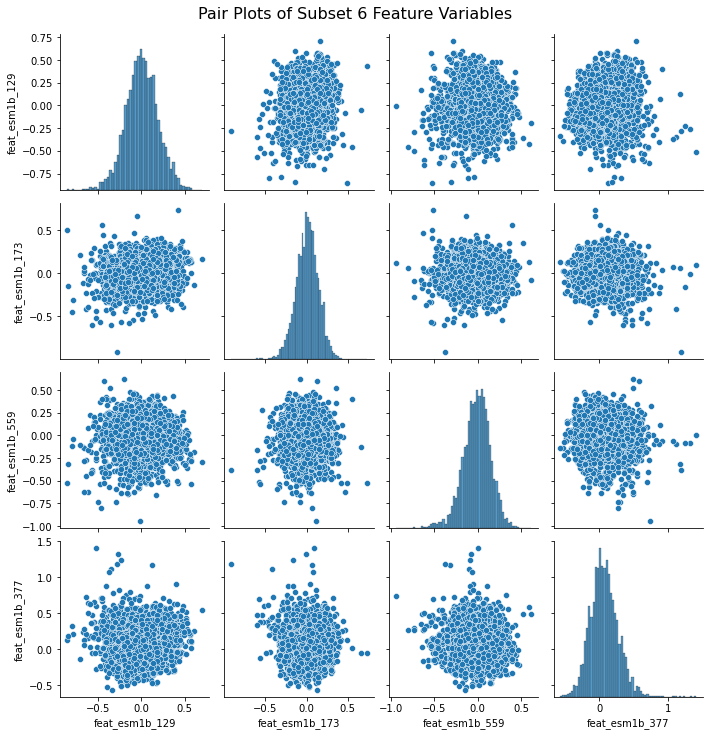

In [243]:
n_subsets = 6
features_per_subset = 4

# Create a list of feature indices
feature_indices = list(range(dataset_1.shape[1]))

# Randomly shuffle the feature indices
random.shuffle(feature_indices)

# Loop through each subset
for i in range(n_subsets):
    # Select a subset of features
    subset_indices = feature_indices[i * features_per_subset: (i + 1) * features_per_subset]
    subset_features = dataset_1.iloc[:, subset_indices]
    
    # Plot the pair plot (scatter plot matrix)
    g = sns.pairplot(subset_features)
    g.fig.suptitle(f"Pair Plots of Subset {i + 1} Feature Variables", y=1.02, fontsize=16)

    # Show the plot
    plt.show()

Pair plots were created for six random subsets of features, where each pair of features within a subset is plotted against each other in a scatter plot. These plots allow us to visualize the relationships and correlations between pairs of features. By examining the pair plots, we can identify trends, patterns, and potential dependencies between different feature

### Checking scales of variables

The `describe` method in pandas generates basic statistics for each numerical column in our dataset, including the count, mean, standard deviation, minimum, maximum, and quartiles. This allows us to identify potential issues, such as features with a much larger scale than others, which may need to be normalized or scaled before modeling. We can also use the `transpose` method to display the statistics in a more readable and organized way.

In [244]:
dataset_1.describe().transpose().round(2)

count        mean        std       min       25%  \
Info_organism_id  4946.0  1023238.57  810517.67  11041.00  12305.00   
Info_pos          4946.0      459.83     437.99      1.00    113.00   
Info_cluster      4946.0       79.88      75.36     34.00     34.00   
Class             4946.0       -0.54       0.84     -1.00     -1.00   
feat_esm1b_0      4425.0        0.03       0.17     -0.86     -0.07   
...                  ...         ...        ...       ...       ...   
feat_esm1b_1275   4425.0       -0.14       0.16     -0.72     -0.25   
feat_esm1b_1276   4425.0        0.04       0.19     -0.73     -0.09   
feat_esm1b_1277   4425.0        0.01       0.16     -0.71     -0.08   
feat_esm1b_1278   4425.0        0.01       0.20     -1.08     -0.12   
feat_esm1b_1279   4425.0        0.25       0.21     -0.98      0.15   

                         50%         75%         max  
Info_organism_id  1678143.00  1678143.00  1678143.00  
Info_pos              326.00      616.00     2498.00  
Info_cluster           35.00      150.00      320.00  
Class                  -1.00       -1.00        1.00  
feat_esm1b_0            0.04        0.15        0.73  
...                      ...         ...         ...  
feat_esm1b_1275        -0.15       -0.05        0.78  
feat_esm1b_1276         0.03        0.16        0.74  
feat_esm1b_1277         0.02        0.11        0.55  
feat_esm1b_1278         0.03        0.15        0.64  
feat_esm1b_1279         0.27        0.39        0.96  

[1284 rows x 8 columns]

### Checking class balance

In the class balance checking step of the data mining pipeline, we examine the distribution of the target class in our dataset to ensure that there are sufficient observations for each class and that the dataset is not imbalanced. This is important because imbalanced datasets can lead to biased or inaccurate models, where the minority class may be overlooked or underrepresented. By checking the class balance, we can identify any class imbalance issues and decide whether to adjust the dataset through resampling or weighting techniques before proceeding with modeling.

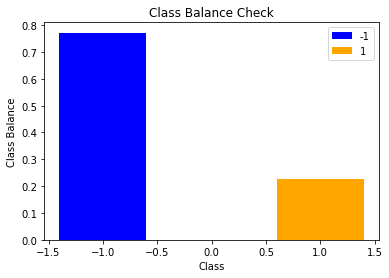

In [245]:
class_counts = dataset_1['Class'].value_counts()
n_classes = len(class_counts)
class_names = list(class_counts.index)

# calculate class balance
class_balance = class_counts / class_counts.sum()

# plot class balance
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(class_names, class_balance, color=['blue', 'orange'])
ax.set_xlabel('Class')
ax.set_ylabel('Class Balance')
ax.set_title('Class Balance Check')
ax.legend(bars, class_names, loc='best')
plt.show()

## Data Preprocessing

In the data preprocessing step of the data mining pipeline, we will prepare our dataset for modeling by addressing any missing values, handling categorical variables, normalizing or scaling features if necessary, and splitting the dataset into training and testing sets.

### Treatment of missing data

I will now proceed to remove the missing data identified during the **EDA** to ensure the quality and reliability of my dataset.

In [246]:
dataset_1_filtered = dataset_1.dropna()

Next step is to filter the dataset by removing any unnecessary columns that were described in the coursework brief. Specifically, removing the columns starting with "Info_", which contain general information about the origin of the observations, and therefore are not useful for modeling purposes. I will be keeping the feature columns starting with "feat_", which contain features that were calculated for each observation.

After removing the unnecessary columns, I then split the filtered data into separate feature and target variables, X and y, respectively, in order to prepare the dataset for further processing and modeling.

In [247]:
X = dataset_1_filtered.filter(regex='^feat_')
y = dataset_1_filtered.loc[X.index, 'Class']

I will now split the filtered data into separate training and testing sets based on the groups informed in the Info_cluster variable.

This is an important step in preparing my dataset for modeling as it ensures that the training and testing sets are representative of the data as a whole and are not biased towards any particular group or cluster. By splitting the data based on the Info_cluster variable, I can ensure that the training and testing sets contain a representative sample of observations from each group, which is especially important if there are significant differences between the groups in terms of the target variable or other important features.

After splitting the data into training and testing sets, I can use the training set to train my models and the testing set to evaluate the performance of my models on unseen data. By evaluating my models on a separate testing set, I can ensure that my models are generalizable and not overfitting to the training data, leading to better performance and results on new data.

In [248]:
info_columns = dataset_1.loc[X.index].filter(regex='^Info_')
info_cluster = info_columns['Info_cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    stratify=info_cluster,
                                                    random_state = 42
                                                   )

X_train.shape, y_train.shape

((3540, 1280), (3540,))

 I will only be using the training set for further data preprocessing steps such as outlier removal, feature reduction, class balancing, and scaling. This is because these steps are part of the model development process and should only be applied to the training set to

### Treatment of outliers

Now , I will dropping the outliers identified during the **EDA**. I am removing the outliers from my dataset excluding the `Class` variable and the `Info_` variables. This is because the `Info_` variables contain general information about the origin of the observations and are not useful for modeling purposes, while the target variable is what we are trying to predict and should not be modified.

In [249]:
X_train_without_outliers = X_train[(z_scores <= threshold).all(axis=1)]
y_train = dataset_1_filtered.loc[X_train_without_outliers.index, 'Class']

X_train_without_outliers.shape, y_train.shape

((1583, 1280), (1583,))

### Feature scaling

As part of the data preprocessing step, I will be scaling the training dataset using the StandardScaler method before performing feature reduction using Boruta. StandardScaler is a commonly used scaling method that scales the data to have zero mean and unit variance.

The purpose of scaling the data before feature reduction is to ensure that all features have a similar range of values and are on the same scale. Boruta compares the importance of each feature in the original dataset to that of random shadow features generated by permuting the values of each feature. Since Boruta uses a random forest algorithm to compare feature importance, scaling the data helps to ensure that the algorithm is not biased towards features with larger values.

Additionally, scaling the data can help to reduce the impact of outliers on the feature selection process. Outliers can have a significant impact on the importance estimates of individual features, leading to biased or inaccurate results. Scaling the data can help to reduce the impact of outliers by normalizing the features and making them less sensitive to extreme values.

In [250]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_without_outliers)

In [251]:
X_train_scaled.shape, y_train.shape

((1583, 1280), (1583,))

## Feature reduction

I will be performing feature reduction using Boruta. Boruta is a wrapper-based feature selection algorithm that works by comparing the importance of each feature in the original dataset to that of random shadow features generated by permuting the values of each feature. The algorithm then selects the features that are significantly more important than their shadow counterparts, indicating that they are likely to be truly informative for the modeling process.

Feature reduction is an important step in preparing the dataset for modeling, particularly when working with high-dimensional datasets with a large number of features. Our dataset has 1280 columns after preprocessing which can make the training process computationally expensive and may lead to overfitting, where the model is too complex and performs well on the training data but poorly on new data.

Boruta is a popular feature selection algorithm that has been shown to be effective in identifying informative features in high-dimensional datasets.

In [252]:
# Perfom boruta
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=1, random_state=42)
boruta_selector.fit(X_train_scaled, y_train.values)


n_relevant_features = boruta_selector.n_features_

# print the number of relevant features
print(f"Number of relevant features: {n_relevant_features}")

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

In [253]:
# get selected features
selected_features = X_train_without_outliers.columns[boruta_selector.support_].tolist()

# print selected features
print(selected_features)

['feat_esm1b_1', 'feat_esm1b_2', 'feat_esm1b_3', 'feat_esm1b_6', 'feat_esm1b_7', 'feat_esm1b_15', 'feat_esm1b_16', 'feat_esm1b_18', 'feat_esm1b_21', 'feat_esm1b_27', 'feat_esm1b_46', 'feat_esm1b_51', 'feat_esm1b_52', 'feat_esm1b_53', 'feat_esm1b_57', 'feat_esm1b_63', 'feat_esm1b_70', 'feat_esm1b_76', 'feat_esm1b_80', 'feat_esm1b_83', 'feat_esm1b_86', 'feat_esm1b_87', 'feat_esm1b_90', 'feat_esm1b_92', 'feat_esm1b_93', 'feat_esm1b_94', 'feat_esm1b_101', 'feat_esm1b_105', 'feat_esm1b_112', 'feat_esm1b_134', 'feat_esm1b_140', 'feat_esm1b_148', 'feat_esm1b_149', 'feat_esm1b_151', 'feat_esm1b_154', 'feat_esm1b_159', 'feat_esm1b_161', 'feat_esm1b_162', 'feat_esm1b_178', 'feat_esm1b_179', 'feat_esm1b_181', 'feat_esm1b_185', 'feat_esm1b_203', 'feat_esm1b_210', 'feat_esm1b_217', 'feat_esm1b_228', 'feat_esm1b_236', 'feat_esm1b_245', 'feat_esm1b_246', 'feat_esm1b_247', 'feat_esm1b_253', 'feat_esm1b_257', 'feat_esm1b_259', 'feat_esm1b_260', 'feat_esm1b_267', 'feat_esm1b_277', 'feat_esm1b_279', 'fea

In [254]:
X_train_selected = boruta_selector.transform(X_train_scaled)
X_train_selected.shape, y_train.shape

((1583, 276), (1583,))

## Data Rebalancing

In [255]:
# Checking the class balance in our training dataset
y_train.value_counts()

-1    1157
 1     426
Name: Class, dtype: int64

I will be performing class balancing to address the class imbalance issue in the dataset. Class imbalance occurs when one class has significantly fewer samples than the other class, leading to biased or inaccurate results in the modeling process. It is an important step in preparing the dataset for modeling, particularly when working with classification problems. Imbalanced classes can lead to biased models that perform poorly on the minority class, leading to inaccurate or unreliable predictions.

I will be using an oversampling technique called RandomOverSampler from the imblearn library to address the class imbalance issue in the dataset. RandomOverSampler is an oversampling technique that randomly samples from the minority class with replacement to create new synthetic samples. It is a simple but effective oversampling technique that can help to balance the classes and reduce the impact of class imbalance on the modeling process. By generating synthetic samples, it helps to improve the performance of the model on the minority class and reduce the impact of class imbalance on the modeling process.

In [256]:
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_selected, y_train)
X_train_resampled.shape, y_train_resampled.shape

((2314, 276), (2314,))

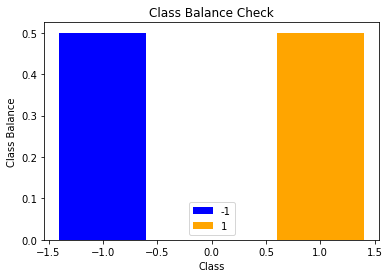

In [257]:
class_counts = y_train_resampled.value_counts()
n_classes = len(class_counts)
class_names = list(class_counts.index)

# calculate class balance
class_balance = class_counts / class_counts.sum()

# plot class balance
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(class_names, class_balance, color=['blue', 'orange'])
ax.set_xlabel('Class')
ax.set_ylabel('Class Balance')
ax.set_title('Class Balance Check')
ax.legend(bars, class_names, loc='best')
plt.show()

## Modelling

RandomForestClassifier, are used to predict the target class of epitopes for Alphavirus. Both models are popular and widely used in classification tasks due to their high accuracy and efficiency. XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable, while RandomForestClassifier is an ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes of the individual trees. These models are trained on the preprocessed training data, and their performance is evaluated on the test data

The function `train_and_evaluate_model` defined below is a utility function that helps to streamline the modeling process. It takes in a set of features, a target variable, and a machine learning model, and trains and evaluates the model using the ROC AUC score as the evaluation metric. By using this function, I can quickly iterate through different models and find the best one based on its performance on the validation set. This can help to speed up the modeling process.

In [258]:
def train_and_evaluate_model(features, target, model):
    
    # Splitting the train set into train and validation
    train_features, test_features, train_target, test_target = train_test_split(features, target,
                                                                                test_size=.1, 
                                                                                random_state = 42,)
    
    # Training the model
    model.fit(train_features, train_target)
    
    # Making predictions on the model
    predictions = model.predict(test_features)
    
    # Evaluating the model on the validation set
    auc_score = roc_auc_score(test_target, predictions)
    
    return auc_score

In order to fine-tune the hyperparameters of the `XGBoost` and `RandomForestClassifier` models, a `GridSearchCV` approach is used. This method performs an exhaustive search over specified parameter values for an estimator, where the parameters are optimized by cross-validation. It helps to find the best hyperparameters for the model, which in turn improves the performance and accuracy of the model. 

In [259]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

rf_clf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_clf, param_grid=rf_params, cv=2, verbose=10)
rf_grid.fit(X_train_resampled, y_train_resampled)

Fitting 2 folds for each of 108 candidates, totalling 216 fits
[CV 1/2; 1/108] START criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/2; 1/108] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.888 total time=   0.6s
[CV 2/2; 1/108] START criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 2/2; 1/108] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.868 total time=   0.6s
[CV 1/2; 2/108] START criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 1/2; 2/108] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.891 total time=   1.0s
[CV 2/2; 2/108] START criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200
[CV 2/2; 2/108] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_

[CV 2/2; 17/108] END criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.865 total time=   0.5s
[CV 1/2; 18/108] START criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200
[CV 1/2; 18/108] END criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.886 total time=   0.9s
[CV 2/2; 18/108] START criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200
[CV 2/2; 18/108] END criterion=gini, max_depth=5, min_samples_leaf=4, min_samples_split=10, n_estimators=200;, score=0.861 total time=   1.0s
[CV 1/2; 19/108] START criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/2; 19/108] END criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.915 total time=   0.7s
[CV 2/2; 19/108] START criterion=gini, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_est

[CV 1/2; 34/108] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.907 total time=   1.3s
[CV 2/2; 34/108] START criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200
[CV 2/2; 34/108] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.907 total time=   1.4s
[CV 1/2; 35/108] START criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 1/2; 35/108] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.913 total time=   0.6s
[CV 2/2; 35/108] START criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 2/2; 35/108] END criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=0.904 total time=   0.7s
[CV 1/2; 36/108] START criterion=gini, max_depth=10, min_samples_leaf=4, min_samples_split=10, 

[CV 2/2; 50/108] END criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.914 total time=   1.4s
[CV 1/2; 51/108] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=100
[CV 1/2; 51/108] END criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.917 total time=   0.7s
[CV 2/2; 51/108] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=100
[CV 2/2; 51/108] END criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=0.909 total time=   0.7s
[CV 1/2; 52/108] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=200
[CV 1/2; 52/108] END criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=5, n_estimators=200;, score=0.917 total time=   1.3s
[CV 2/2; 52/108] START criterion=gini, max_depth=15, min_samples_leaf=4, min_samples_split=5, n_est

[CV 2/2; 66/108] END criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.870 total time=   1.3s
[CV 1/2; 67/108] START criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 1/2; 67/108] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.875 total time=   0.7s
[CV 2/2; 67/108] START criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 2/2; 67/108] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=0.868 total time=   0.8s
[CV 1/2; 68/108] START criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200
[CV 1/2; 68/108] END criterion=entropy, max_depth=5, min_samples_leaf=4, min_samples_split=2, n_estimators=200;, score=0.884 total time=   1.7s
[CV 2/2; 68/108] START criterion=entropy, max_depth=5, min_samples_leaf=4, min_sampl

[CV 2/2; 82/108] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.913 total time=   1.8s
[CV 1/2; 83/108] START criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 1/2; 83/108] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.918 total time=   0.8s
[CV 2/2; 83/108] START criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 2/2; 83/108] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=0.912 total time=   0.9s
[CV 1/2; 84/108] START criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200
[CV 1/2; 84/108] END criterion=entropy, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.922 total time=   1.7s
[CV 2/2; 84/108] START criterion=entropy, max_depth=10, min_samples_leaf

[CV 2/2; 98/108] END criterion=entropy, max_depth=15, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.915 total time=   2.0s
[CV 1/2; 99/108] START criterion=entropy, max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 1/2; 99/108] END criterion=entropy, max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.914 total time=   1.3s
[CV 2/2; 99/108] START criterion=entropy, max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 2/2; 99/108] END criterion=entropy, max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=0.912 total time=   1.0s
[CV 1/2; 100/108] START criterion=entropy, max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=200
[CV 1/2; 100/108] END criterion=entropy, max_depth=15, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=0.920 total time=   1.8s
[CV 2/2; 100/108] START criterion=entropy, max_depth=15, min_samples_leaf=2,

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]},
             verbose=10)

In [260]:
print("Random Forest: Best parameters: ", rf_grid.best_params_)
print("Random Forest: Best score: ", rf_grid.best_score_)

Random Forest: Best parameters:  {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest: Best score:  0.9235090751944685


In [261]:
# Training the model with the best hyperparemeters found during gridsearch
rf_model = rf_grid.best_estimator_
train_and_evaluate_model(X_train_resampled, y_train_resampled, rf_model)

0.9462365591397849

To evaluate the performance of the XGBoost and RandomForestClassifier models on the test data, the functions `preprocess_and_test_model` is used. It preprocesses the test data, applies feature reduction and scaling using a specified feature extractor and scaler, and finally evaluates the model by predicting the target class of the test data and computing the AUC score. The function takes in the test data, target, the scaler and feature extractor used during training, and the trained model as inputs. The test data is preprocessed by scaling it using the same scaler used during training, and the reduced set of features is obtained using the feature extractor specified during training. The model is then used to predict the target class of the test data, and the AUC score is computed to evaluate the performance of the model. 

In [262]:
def plot_roc_curve(model, X_test, y_test):
    # Predict probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [263]:
def preprocess_and_test_model(test_data, test_target, scaler, feature_extractor, model):
    test_data_scaled = scaler.transform(test_data)
    test_data_selected = feature_extractor.transform(test_data_scaled)
    test_preds = model.predict(test_data_selected)
    auc_score = roc_auc_score(test_target, test_preds)
    print(f'AUC score: {auc_score}')
    return test_data_selected, test_target, test_preds

In [264]:
# Evaluating RandomForestClassifier model on the test dataset
test_data_clean, test_targets_clean, test_preds = preprocess_and_test_model(X_test, y_test, scaler, boruta_selector, rf_model)

AUC score: 0.735328190590416


The `plot_classification_summary` function is used to create a summary plot of the classification model. It takes as input the trained model, training and test data, and outputs a grid of subplots. The subplots include the confusion matrix, ROC curve, and precision-recall curve. The function also calculates and shows the learning curves for the model. The confusion matrix shows the true positive, true negative, false positive, and false negative values for the model. The ROC curve and precision-recall curve show the performance of the model on the test data. The learning curves provide insights into the important features and how the model's performance improves with more training data. Overall, this function provides a comprehensive view of the model's performance and can aid in model selection and interpretation.

In [265]:
def plot_classification_summary(model, X_train, X_test, y_train, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

    # Feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)

    # Learning curve
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=5, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    # Create a grid of subplots
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    
    # Confusion matrix plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axs[0, 0])
    axs[0, 0].set_xlabel('Predicted')
    axs[0, 0].set_ylabel('Actual')
    axs[0, 0].set_title('Confusion Matrix')
    
    # ROC curve plot
    axs[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    axs[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[0, 1].set_xlim([0.0, 1.0])
    axs[0, 1].set_ylim([0.0, 1.05])
    axs[0, 1].set_xlabel('False Positive Rate')
    axs[0, 1].set_ylabel('True Positive Rate')
    axs[0, 1].set_title('ROC Curve')
    axs[0, 1].legend(loc="lower right")

    # Precision-recall curve plot
    axs[1, 0].plot(recall, precision, lw=2, label='Precision-Recall curve')
    axs[1, 0].set_xlim([0.0, 1.0])
    axs[1, 0].set_ylim([0.0, 1.05])
    axs[1, 0].set_xlabel('Recall')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_title('Precision-Recall Curve')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


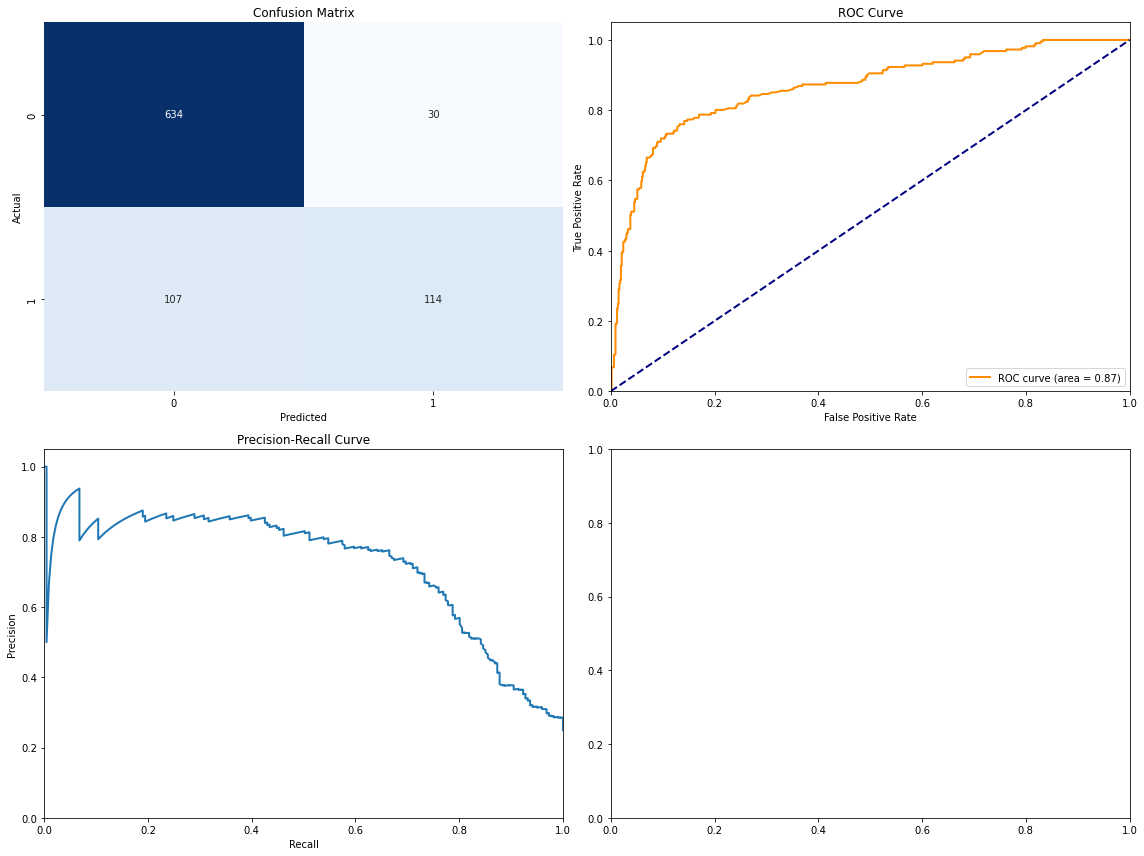

In [266]:
plot_classification_summary(rf_model, X_train_resampled, test_data_clean, y_train_resampled, test_targets_clean)

#### Predicting on XGB boost

In [267]:
y_train_resampled_xgb = y_train_resampled.copy(deep=True)
y_train_resampled_xgb[y_train_resampled_xgb == -1] = 0

xgb_params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 0.1, 0.3]
}

xgb_clf = xgb.XGBClassifier(random_state=42)
xgb_grid = GridSearchCV(xgb_clf, param_grid=xgb_params, cv=3, verbose=10)
xgb_grid.fit(X_train_resampled, y_train_resampled_xgb)

print("XGBoost: Best parameters: ", xgb_grid.best_params_)
print("XGBoost: Best score: ", xgb_grid.best_score_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3; 1/81] START gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50..
[CV 1/3; 1/81] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.804 total time=   0.3s
[CV 2/3; 1/81] START gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50..
[CV 2/3; 1/81] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.773 total time=   0.3s
[CV 3/3; 1/81] START gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50..
[CV 3/3; 1/81] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.811 total time=   0.3s
[CV 1/3; 2/81] START gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100.
[CV 1/3; 2/81] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.834 total time=   0.6s
[CV 2/3; 2/81] START gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100.
[CV 2/3; 2/81] END gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.798 

[CV 2/3; 15/81] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.939 total time=   1.7s
[CV 3/3; 15/81] START gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200.
[CV 3/3; 15/81] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=200;, score=0.925 total time=   1.6s
[CV 1/3; 16/81] START gamma=0, learning_rate=0.1, max_depth=7, n_estimators=50..
[CV 1/3; 16/81] END gamma=0, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.944 total time=   0.6s
[CV 2/3; 16/81] START gamma=0, learning_rate=0.1, max_depth=7, n_estimators=50..
[CV 2/3; 16/81] END gamma=0, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.938 total time=   0.8s
[CV 3/3; 16/81] START gamma=0, learning_rate=0.1, max_depth=7, n_estimators=50..
[CV 3/3; 16/81] END gamma=0, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.923 total time=   0.8s
[CV 1/3; 17/81] START gamma=0, learning_rate=0.1, max_depth=7, n_estimators=100.
[CV 1/3; 17/81] END gamma=0, learning_rate=

[CV 3/3; 29/81] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.827 total time=   0.6s
[CV 1/3; 30/81] START gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200
[CV 1/3; 30/81] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.878 total time=   1.1s
[CV 2/3; 30/81] START gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200
[CV 2/3; 30/81] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.822 total time=   1.2s
[CV 3/3; 30/81] START gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200
[CV 3/3; 30/81] END gamma=0.1, learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.853 total time=   1.2s
[CV 1/3; 31/81] START gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50
[CV 1/3; 31/81] END gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50;, score=0.851 total time=   0.5s
[CV 2/3; 31/81] START gamma=0.1, learning_rate=0.01, max_depth=5, n_estimators=50
[CV 2/3; 31/81] EN

[CV 3/3; 43/81] END gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=50;, score=0.929 total time=   0.8s
[CV 1/3; 44/81] START gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=100
[CV 1/3; 44/81] END gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=100;, score=0.939 total time=   1.2s
[CV 2/3; 44/81] START gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=100
[CV 2/3; 44/81] END gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=100;, score=0.944 total time=   1.2s
[CV 3/3; 44/81] START gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=100
[CV 3/3; 44/81] END gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=100;, score=0.934 total time=   1.3s
[CV 1/3; 45/81] START gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200
[CV 1/3; 45/81] END gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.940 total time=   2.2s
[CV 2/3; 45/81] START gamma=0.1, learning_rate=0.1, max_depth=7, n_estimators=200
[CV 2/3; 45/81] END gamma=

[CV 1/3; 58/81] END gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=50;, score=0.856 total time=   0.7s
[CV 2/3; 58/81] START gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=50
[CV 2/3; 58/81] END gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=50;, score=0.877 total time=   0.8s
[CV 3/3; 58/81] START gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=50
[CV 3/3; 58/81] END gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=50;, score=0.870 total time=   0.7s
[CV 1/3; 59/81] START gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=100
[CV 1/3; 59/81] END gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.882 total time=   1.2s
[CV 2/3; 59/81] START gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=100
[CV 2/3; 59/81] END gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.874 total time=   1.2s
[CV 3/3; 59/81] START gamma=0.3, learning_rate=0.01, max_depth=5, n_estimators=100
[CV 3/3; 59/81] END 

[CV 1/3; 72/81] END gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.939 total time=   2.0s
[CV 2/3; 72/81] START gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=200
[CV 2/3; 72/81] END gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.946 total time=   2.1s
[CV 3/3; 72/81] START gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=200
[CV 3/3; 72/81] END gamma=0.3, learning_rate=0.1, max_depth=7, n_estimators=200;, score=0.925 total time=   2.0s
[CV 1/3; 73/81] START gamma=0.3, learning_rate=0.3, max_depth=3, n_estimators=50
[CV 1/3; 73/81] END gamma=0.3, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.935 total time=   0.3s
[CV 2/3; 73/81] START gamma=0.3, learning_rate=0.3, max_depth=3, n_estimators=50
[CV 2/3; 73/81] END gamma=0.3, learning_rate=0.3, max_depth=3, n_estimators=50;, score=0.914 total time=   0.3s
[CV 3/3; 73/81] START gamma=0.3, learning_rate=0.3, max_depth=3, n_estimators=50
[CV 3/3; 73/81] END gamma=0.3,

In [268]:
xgb_model = xgb_grid.best_estimator_
train_and_evaluate_model(X_train_resampled, y_train_resampled_xgb, xgb_model)

0.9317502986857825

In [269]:
y_test_xgb = y_test.copy(deep=True)
y_test_xgb[y_test_xgb == -1] = 0
test_data_clean, test_targets_clean, test_preds = preprocess_and_test_model(X_test, y_test_xgb, scaler, boruta_selector, xgb_model)

AUC score: 0.7707844954478548


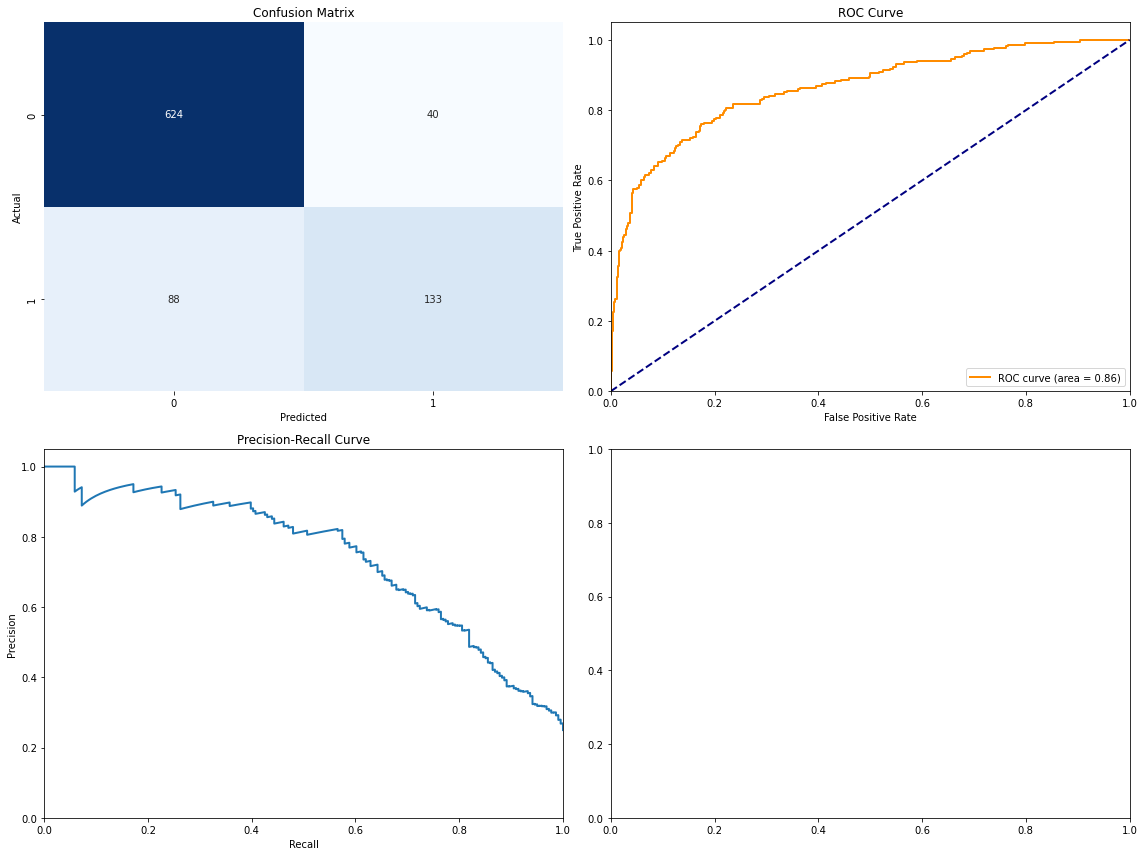

In [270]:
plot_classification_summary(xgb_model, X_train_resampled, test_data_clean, y_train_resampled, test_targets_clean)

> XGBoost model has a higher AUC score on the test set (0.77) compared to the Random Forest model (0.73). However, the Random Forest model has a higher AUC score on the training set (0.94) compared to the XGBoost model (0.931).

# Data Mining Pipeline for Dataset 3

In [187]:
dataset_2 = pd.read_csv('df_training_level3(1).csv')

## Exploratory Data Analysis (EDA)

In [188]:
dataset_2.head()

Info_PepID  Info_organism_id Info_protein_id  Info_pos Info_AA  \
0  NP_775663.1:2             11072     NP_775663.1         2       T   
1  NP_775663.1:2             11072     NP_775663.1         3       K   
2  NP_775663.1:2             11072     NP_775663.1         4       K   
3  NP_775663.1:2             11072     NP_775663.1         5       P   
4  NP_775663.1:2             11072     NP_775663.1         6       G   

  Info_pubmed_id Info_epitope_id Info_host_id Info_nPos Info_nNeg  ...  \
0        8725101           64601         9606         2         1  ...   
1        8725101           64601         9606         2         1  ...   
2        8725101           64601         9606         2         1  ...   
3        8725101           64601         9606         2         1  ...   
4        8725101           64601         9606         2         1  ...   

  feat_esm1b_1270 feat_esm1b_1271  feat_esm1b_1272  feat_esm1b_1273  \
0        0.235874       -0.186116        -0.007055         0.227716   
1        0.014759       -0.119949        -0.016030         0.040704   
2        0.066743       -0.165863        -0.061832         0.026400   
3       -0.148641       -0.088860        -0.218482         0.103855   
4        0.251960       -0.122903        -0.191698         0.142125   

   feat_esm1b_1274  feat_esm1b_1275  feat_esm1b_1276  feat_esm1b_1277  \
0        -1.469320         0.024950         0.054577         0.142123   
1        -1.614884         0.189634        -0.049600         0.005898   
2        -1.353973         0.140752        -0.168214         0.114217   
3        -1.252338        -0.000789         0.049453         0.197773   
4        -0.985092         0.029431         0.176924         0.302354   

   feat_esm1b_1278  feat_esm1b_1279  
0         0.194421         0.471760  
1         0.128652         0.254778  
2        -0.002818         0.247916  
3         0.034994         0.303203  
4        -0.138180         0.136602  

[5 rows x 1294 columns]

In [189]:
dataset_2.shape

(72663, 1294)

### Investigating feature types

In [190]:
dataset_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72663 entries, 0 to 72662
Columns: 1294 entries, Info_PepID to feat_esm1b_1279
dtypes: float64(1280), int64(4), object(10)
memory usage: 717.4+ MB


### Checking for missing values

In [191]:
dataset_2.isna().sum()

Info_PepID             0
Info_organism_id       0
Info_protein_id        0
Info_pos               0
Info_AA                0
                    ... 
feat_esm1b_1275     1912
feat_esm1b_1276     1912
feat_esm1b_1277     1912
feat_esm1b_1278     1912
feat_esm1b_1279     1912
Length: 1294, dtype: int64

In [192]:
missing_values_count = dataset_1.isna().sum().sum()
print(f"Total missing values count: {missing_values_count}")

Total missing values count: 666880


### Checking for outliers

In [193]:
filtered_data_2 = dataset_2.drop(columns=['Class']).filter(regex='^(?!Info_)')

In [194]:
z_scores = np.abs((filtered_data_2 - filtered_data_2.mean())/filtered_data_2.std())
threshold = 3
outliers = z_scores > threshold

outlier_indices = np.where(outliers)
# Create a DataFrame with row indices, column indices, and feature names
outlier_info = pd.DataFrame({'Row': outlier_indices[0],
                             'Column': outlier_indices[1],
                             'Feature': filtered_data_2.columns[outlier_indices[1]]})

# Print the DataFrame
print("Outlier Indices (Row, Column, Feature):")
outlier_info

Outlier Indices (Row, Column, Feature):


Row  Column          Feature
0           0     614   feat_esm1b_614
1           0     765   feat_esm1b_765
2           0    1230  feat_esm1b_1230
3           1    1252  feat_esm1b_1252
4           4     493   feat_esm1b_493
...       ...     ...              ...
886507  72631     471   feat_esm1b_471
886508  72647     917   feat_esm1b_917
886509  72652     922   feat_esm1b_922
886510  72654      18    feat_esm1b_18
886511  72654     646   feat_esm1b_646

[886512 rows x 3 columns]

In [195]:
# count total number of True values
n_outliers = outliers.sum().sum()  
print("Total number of outlier records:", n_outliers)

Total number of outlier records: 886512


### Visualizing the dataset

#### Histograms

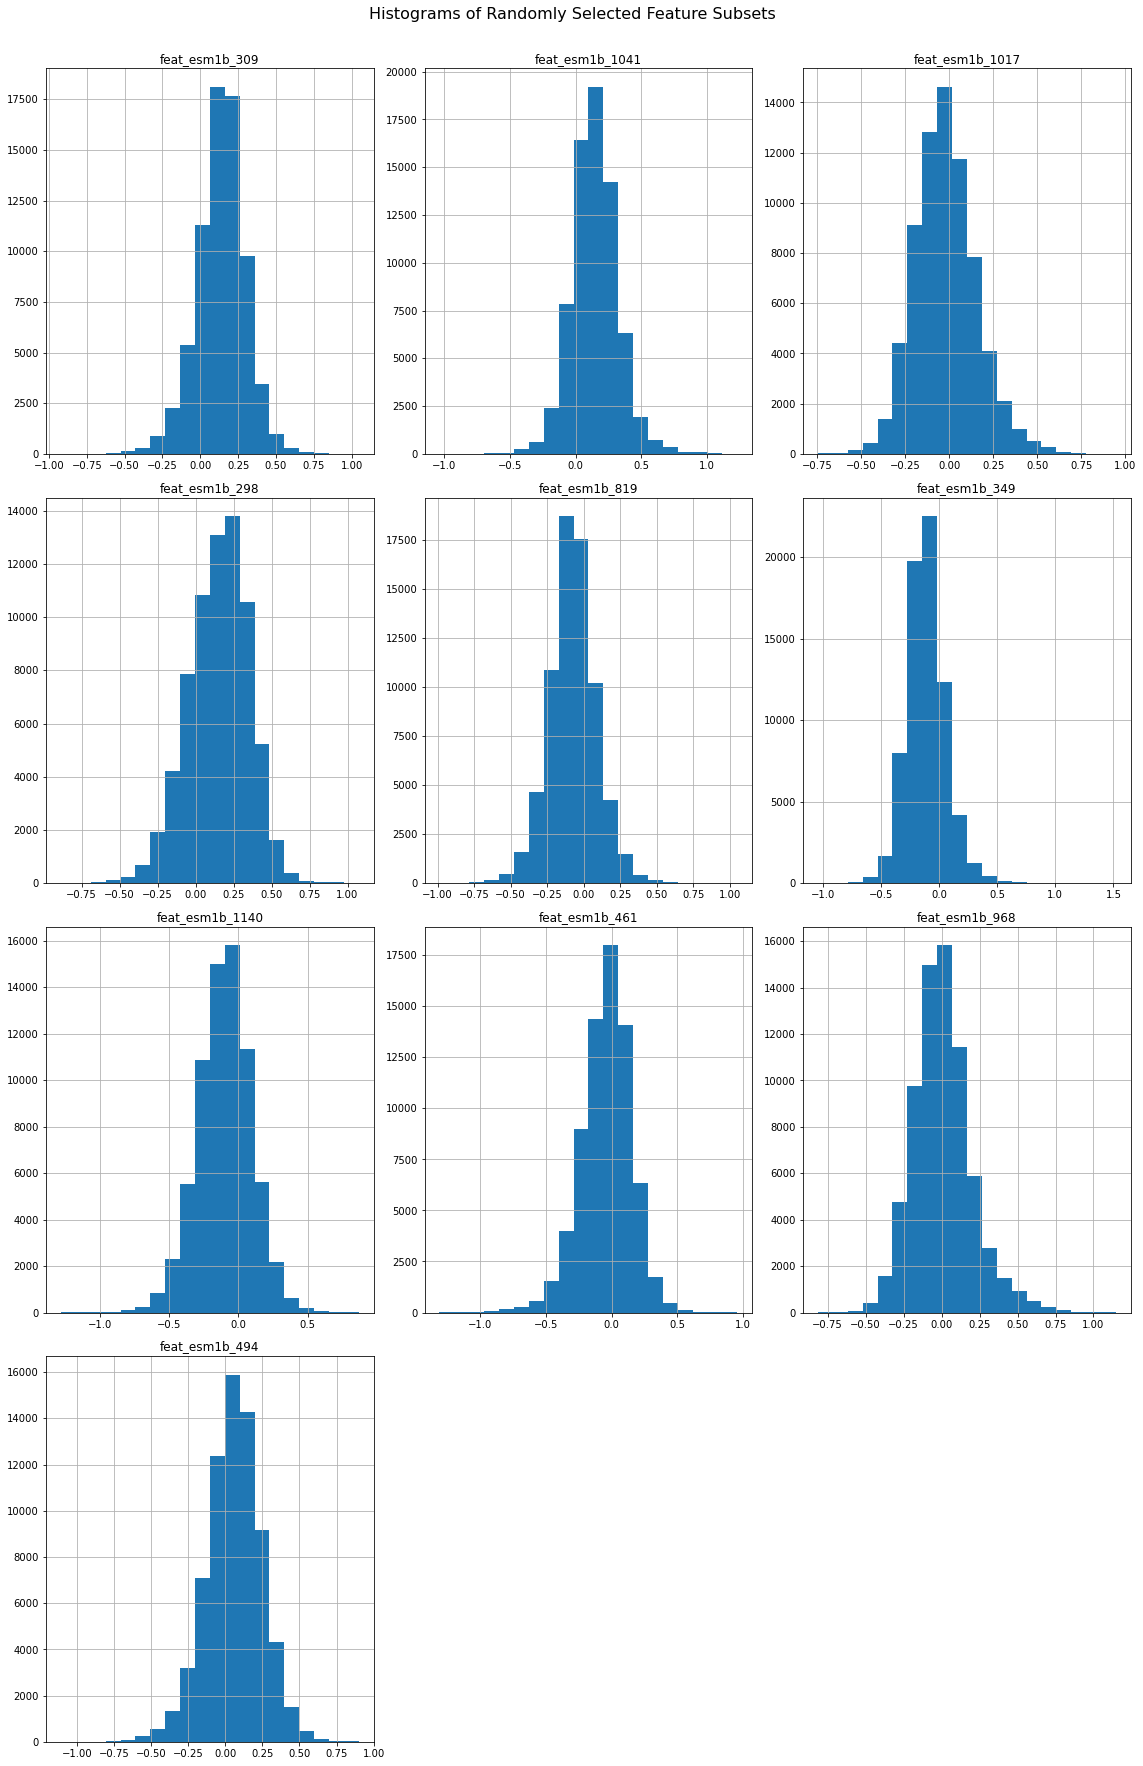

In [196]:
n_subsets = 6
features_per_subset = 10

# Create a list of feature indices
feature_indices = list(range(dataset_2.shape[1]))

# Randomly shuffle the feature indices
random.shuffle(feature_indices)

# Initialize the subplots
fig, axes = plt.subplots(n_subsets, figsize=(16, n_subsets * 4))

# Loop through each subset
for i in range(n_subsets):
    # Select a subset of features
    subset_indices = feature_indices[i * features_per_subset: (i + 1) * features_per_subset]
    subset_features = dataset_2.iloc[:, subset_indices]
    
    # Plot the histograms
    subset_features.hist(ax=axes[i], bins=20)
    axes[i].set_title(f"Histograms of Subset {i + 1} Feature Variables")
    
# Adjust the layout and add a title
plt.tight_layout()
plt.suptitle("Histograms of Randomly Selected Feature Subsets", y=1.02, fontsize=16)
plt.show()

#### Box plots

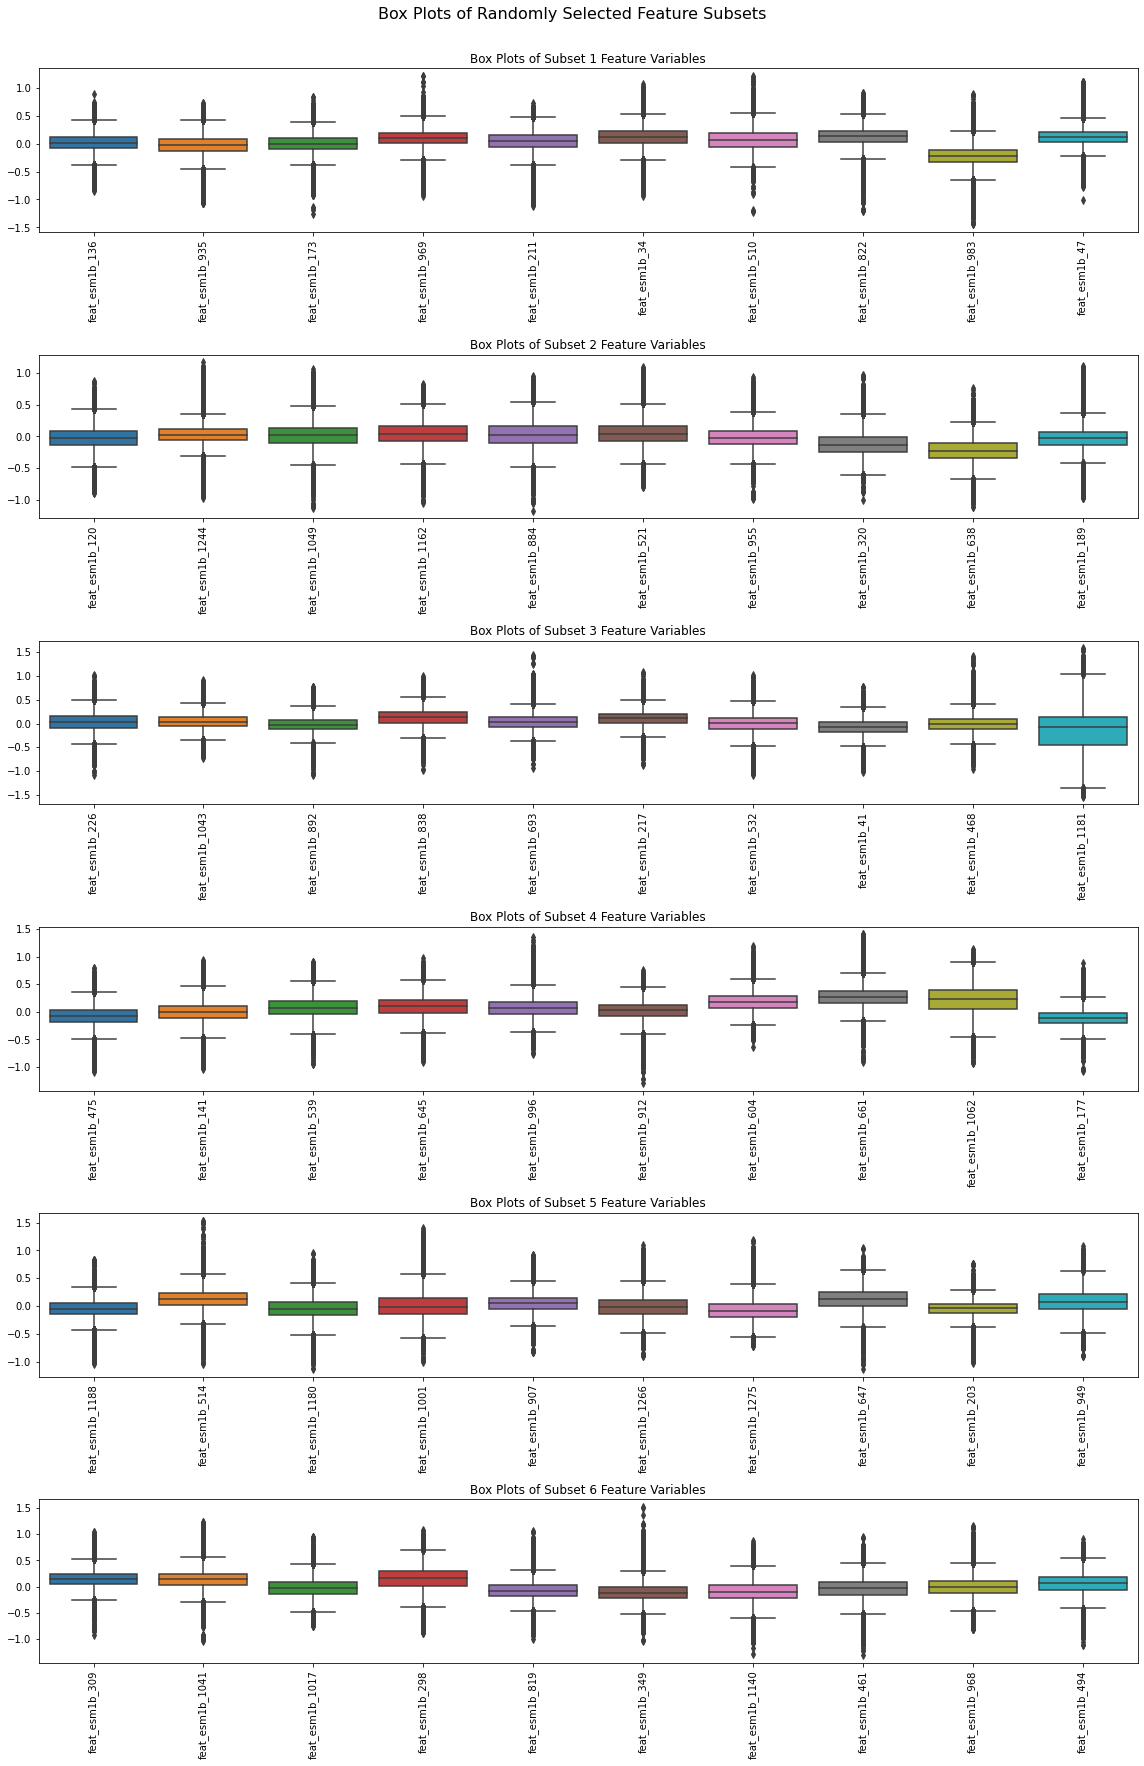

In [197]:
# Initialize the subplots
fig, axes = plt.subplots(n_subsets, figsize=(16, n_subsets * 4))

# Loop through each subset
for i in range(n_subsets):
    # Select a subset of features
    subset_indices = feature_indices[i * features_per_subset: (i + 1) * features_per_subset]
    subset_features = dataset_2.iloc[:, subset_indices]
    
    # Plot the box plots
    sns.boxplot(data=subset_features, ax=axes[i])
    axes[i].set_title(f"Box Plots of Subset {i + 1} Feature Variables")
    axes[i].tick_params(axis='x', rotation=90)

# Adjust the layout and add a title
plt.tight_layout()
plt.suptitle("Box Plots of Randomly Selected Feature Subsets", y=1.02, fontsize=16)
plt.show()

#### Pair plots

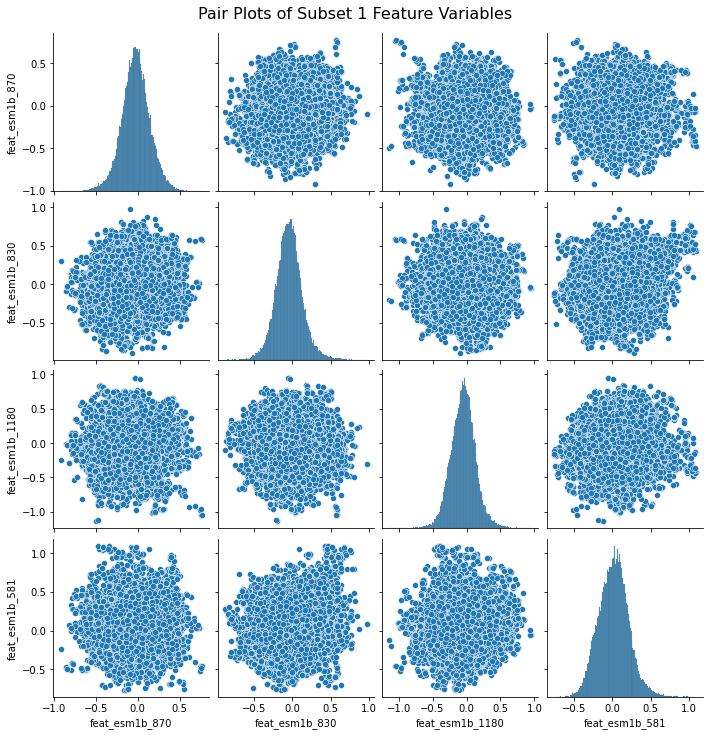

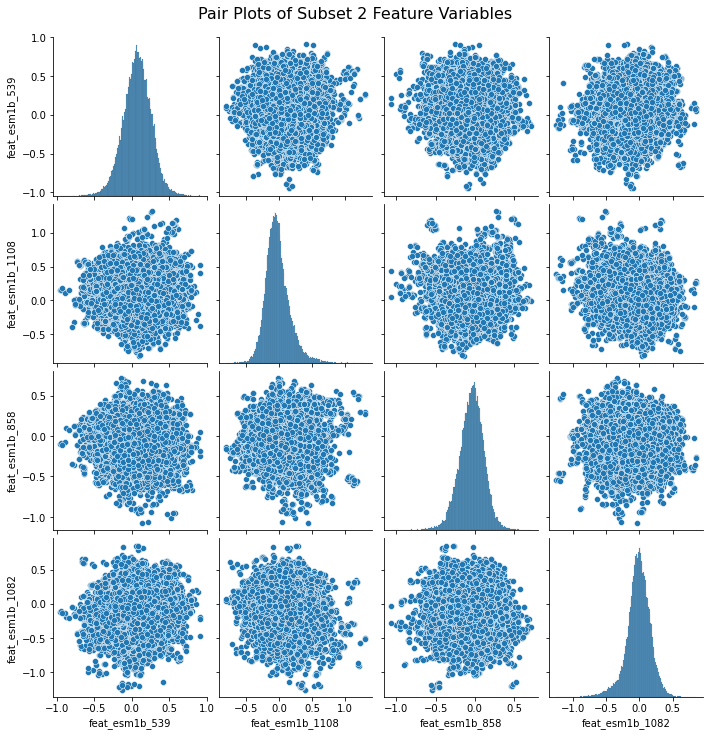

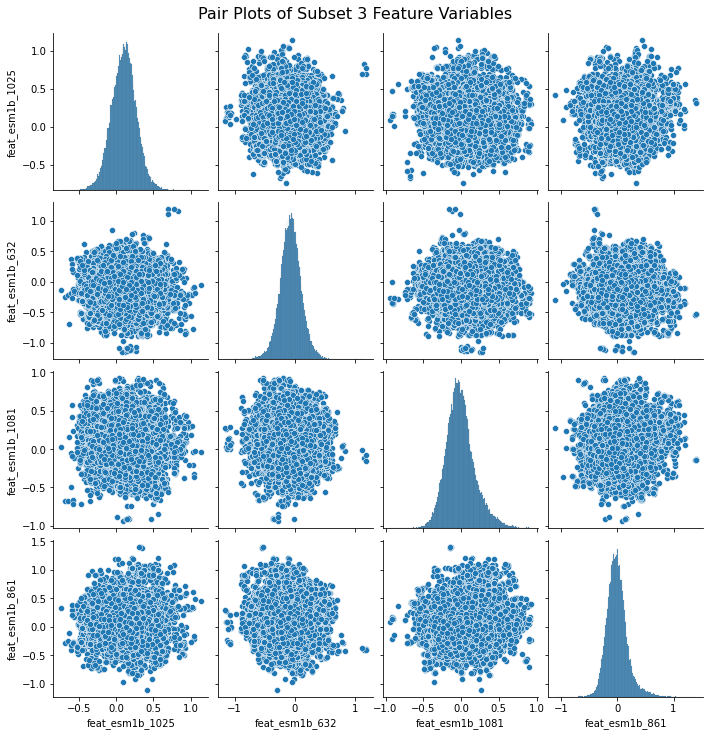

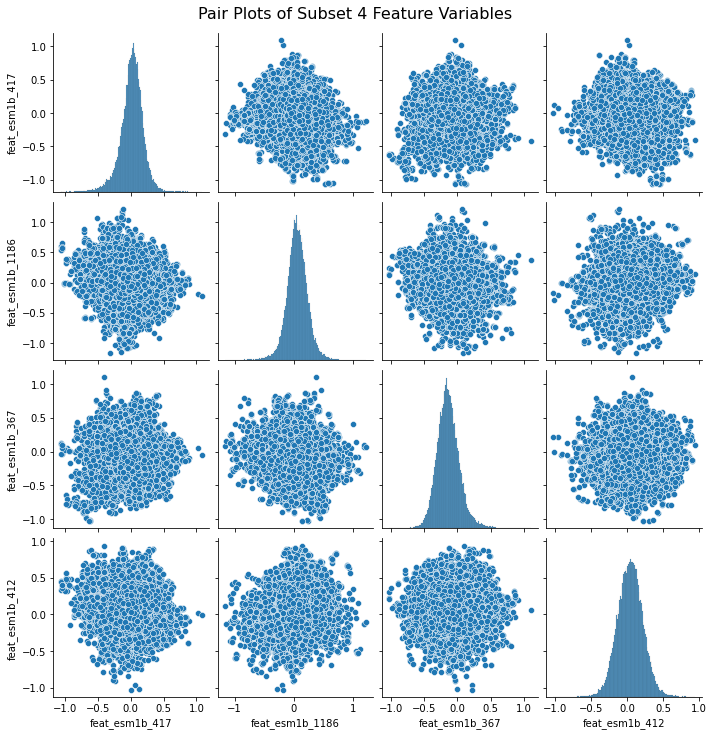

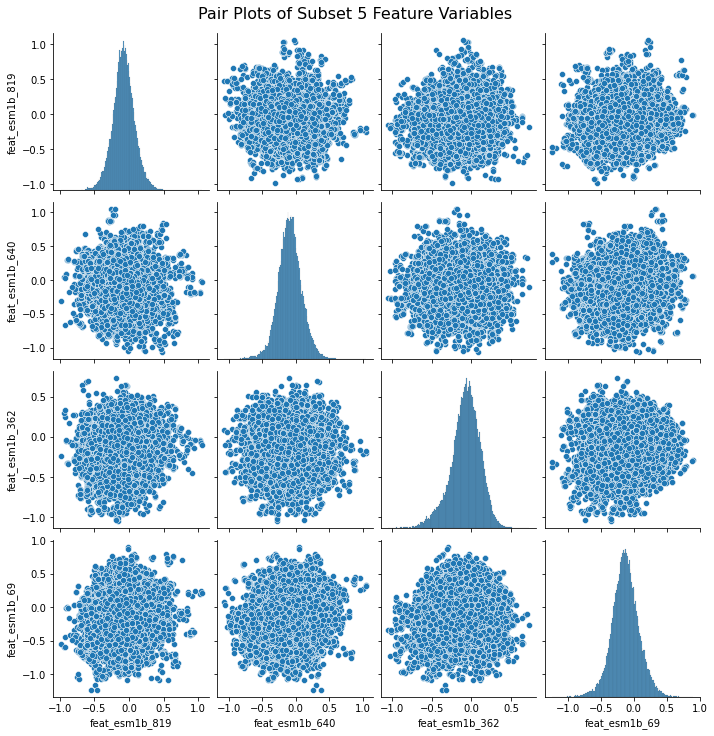

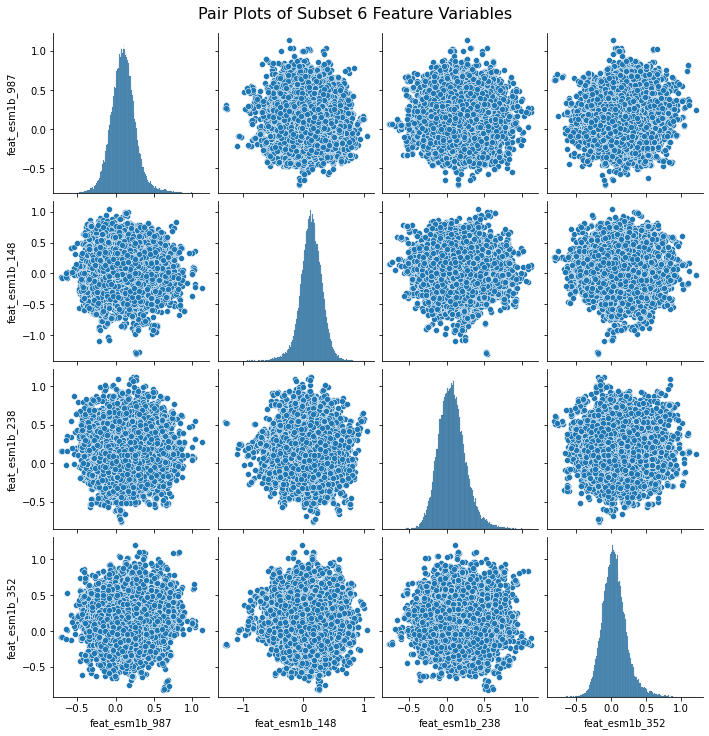

In [198]:
n_subsets = 6
features_per_subset = 4

# Create a list of feature indices
feature_indices = list(range(dataset_2.shape[1]))

# Randomly shuffle the feature indices
random.shuffle(feature_indices)

# Loop through each subset
for i in range(n_subsets):
    # Select a subset of features
    subset_indices = feature_indices[i * features_per_subset: (i + 1) * features_per_subset]
    subset_features = dataset_2.iloc[:, subset_indices]
    
    # Plot the pair plot (scatter plot matrix)
    g = sns.pairplot(subset_features)
    g.fig.suptitle(f"Pair Plots of Subset {i + 1} Feature Variables", y=1.02, fontsize=16)

    # Show the plot
    plt.show()

### Checking the scales of variables

In [199]:
dataset_2.describe().transpose().round(2)

count       mean        std       min       25%       50%  \
Info_organism_id  72663.0  155538.61  492416.88  11041.00  11065.00  11089.00   
Info_pos          72663.0    1201.71     979.76      1.00    352.00    948.00   
Info_cluster      72663.0      20.48      34.71      8.00      8.00      8.00   
Class             72663.0       0.06       1.00     -1.00     -1.00      1.00   
feat_esm1b_0      70751.0       0.02       0.17     -0.97     -0.08      0.03   
...                   ...        ...        ...       ...       ...       ...   
feat_esm1b_1275   70751.0      -0.06       0.20     -0.72     -0.20     -0.08   
feat_esm1b_1276   70751.0       0.07       0.19     -0.82     -0.05      0.06   
feat_esm1b_1277   70751.0      -0.01       0.18     -1.14     -0.10      0.01   
feat_esm1b_1278   70751.0       0.05       0.21     -1.16     -0.07      0.07   
feat_esm1b_1279   70751.0       0.17       0.23     -1.47      0.08      0.21   

                       75%         max  
Info_organism_id  31635.00  2847144.00  
Info_pos           1935.00     3409.00  
Info_cluster         28.00      587.00  
Class                 1.00        1.00  
feat_esm1b_0          0.14        0.93  
...                    ...         ...  
feat_esm1b_1275       0.04        1.18  
feat_esm1b_1276       0.18        1.05  
feat_esm1b_1277       0.10        0.68  
feat_esm1b_1278       0.19        0.89  
feat_esm1b_1279       0.31        0.97  

[1284 rows x 8 columns]

### Checking class balance

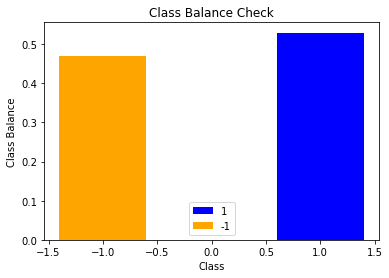

In [200]:
class_counts = dataset_2['Class'].value_counts()
n_classes = len(class_counts)
class_names = list(class_counts.index)

# calculate class balance
class_balance = class_counts / class_counts.sum()

# plot class balance
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(class_names, class_balance, color=['blue', 'orange'])
ax.set_xlabel('Class')
ax.set_ylabel('Class Balance')
ax.set_title('Class Balance Check')
ax.legend(bars, class_names, loc='best')
plt.show()

## Data Preprocessing

In [201]:
dataset_2_filtered = dataset_2.dropna()

In [202]:
X = dataset_2_filtered.filter(regex='^feat_')
y = dataset_2_filtered.loc[X.index, 'Class']

In [203]:
info_columns = dataset_2.loc[X.index].filter(regex='^Info_')
info_cluster = info_columns['Info_cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, 
                                                    stratify=info_cluster,
                                                    random_state = 42
                                                   )

X_train.shape, y_train.shape

((56600, 1280), (56600,))

### Treatment of outliers

In [204]:
X_train_without_outliers = X_train[(z_scores <= threshold).all(axis=1)]
y_train = dataset_2_filtered.loc[X_train_without_outliers.index, 'Class']

X_train_without_outliers.shape, y_train.shape

((31471, 1280), (31471,))

### Feature scaling

In [205]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_without_outliers)

In [206]:
X_train_scaled.shape, y_train.shape

((31471, 1280), (31471,))

## Feature Reduction

In [207]:
# Perfom boruta
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=1, random_state=42)
boruta_selector.fit(X_train_scaled, y_train.values)


n_relevant_features = boruta_selector.n_features_

# print the number of relevant features
print(f"Number of relevant features: {n_relevant_features}")

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100
Iteration: 33 / 100
Iteration: 34 / 100
Iteration: 35 / 100
Iteration: 36 / 100
Iteration: 37 / 100
Iteration: 38 / 100
Iteration: 39 / 100
Iteration: 40 / 100
Iteration: 41 / 100
Iteration: 42 / 100
Iteration: 43 / 100
Iteration: 44 / 100
Iteration: 45 / 100
Iteration: 46 / 100
Iteration: 47 / 100
Iteration: 48 / 100
Iteration: 49 / 100
Iteration: 50 / 100
Iteration

In [208]:
# get selected features
selected_features = X_train_without_outliers.columns[boruta_selector.support_].tolist()

# print selected features
print(selected_features)

['feat_esm1b_1', 'feat_esm1b_2', 'feat_esm1b_5', 'feat_esm1b_6', 'feat_esm1b_7', 'feat_esm1b_9', 'feat_esm1b_10', 'feat_esm1b_11', 'feat_esm1b_12', 'feat_esm1b_13', 'feat_esm1b_15', 'feat_esm1b_16', 'feat_esm1b_18', 'feat_esm1b_20', 'feat_esm1b_21', 'feat_esm1b_22', 'feat_esm1b_23', 'feat_esm1b_25', 'feat_esm1b_30', 'feat_esm1b_31', 'feat_esm1b_34', 'feat_esm1b_36', 'feat_esm1b_38', 'feat_esm1b_40', 'feat_esm1b_41', 'feat_esm1b_42', 'feat_esm1b_45', 'feat_esm1b_46', 'feat_esm1b_48', 'feat_esm1b_50', 'feat_esm1b_51', 'feat_esm1b_52', 'feat_esm1b_53', 'feat_esm1b_54', 'feat_esm1b_55', 'feat_esm1b_58', 'feat_esm1b_60', 'feat_esm1b_61', 'feat_esm1b_62', 'feat_esm1b_64', 'feat_esm1b_65', 'feat_esm1b_67', 'feat_esm1b_68', 'feat_esm1b_69', 'feat_esm1b_70', 'feat_esm1b_75', 'feat_esm1b_76', 'feat_esm1b_77', 'feat_esm1b_78', 'feat_esm1b_79', 'feat_esm1b_80', 'feat_esm1b_81', 'feat_esm1b_82', 'feat_esm1b_83', 'feat_esm1b_84', 'feat_esm1b_86', 'feat_esm1b_87', 'feat_esm1b_88', 'feat_esm1b_90', 'f

In [209]:
X_train_selected = boruta_selector.transform(X_train_scaled)
X_train_selected.shape, y_train.shape

((31471, 915), (31471,))

## Data Rebalancing

In [210]:
# Checking the class balance in our training dataset
y_train.value_counts()

 1    16602
-1    14869
Name: Class, dtype: int64

In [211]:
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_selected, y_train)
X_train_resampled.shape, y_train_resampled.shape

((33204, 915), (33204,))

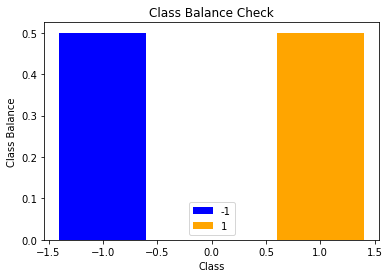

In [212]:
class_counts = y_train_resampled.value_counts()
n_classes = len(class_counts)
class_names = list(class_counts.index)

# calculate class balance
class_balance = class_counts / class_counts.sum()

# plot class balance
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(class_names, class_balance, color=['blue', 'orange'])
ax.set_xlabel('Class')
ax.set_ylabel('Class Balance')
ax.set_title('Class Balance Check')
ax.legend(bars, class_names, loc='best')
plt.show()

## Modelling

Due to limited computational resources and long runtime, the Grid Search CV step for dataset 2 was skipped.

In [217]:
# rf_params = {
#     'n_estimators': [100, 200],
#     'max_depth': [5, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'criterion': ['gini', 'entropy']
# }

# rf_clf = RandomForestClassifier(random_state=42)
# rf_grid = GridSearchCV(rf_clf, param_grid=rf_params, cv=3, verbose=10)
# rf_grid.fit(X_train_resampled, y_train_resampled)

In [218]:
# rf_model_2 = rf_grid.best_estimator_

rf_model_2 = RandomForestClassifier(random_state=42)
train_and_evaluate_model(X_train_resampled, y_train_resampled, rf_model_2)

0.6655844556419277

In [220]:
test_data_clean, test_targets_clean, test_preds = preprocess_and_test_model(X_test, y_test, scaler, boruta_selector, rf_model_2)

AUC score: 0.6053413838688662


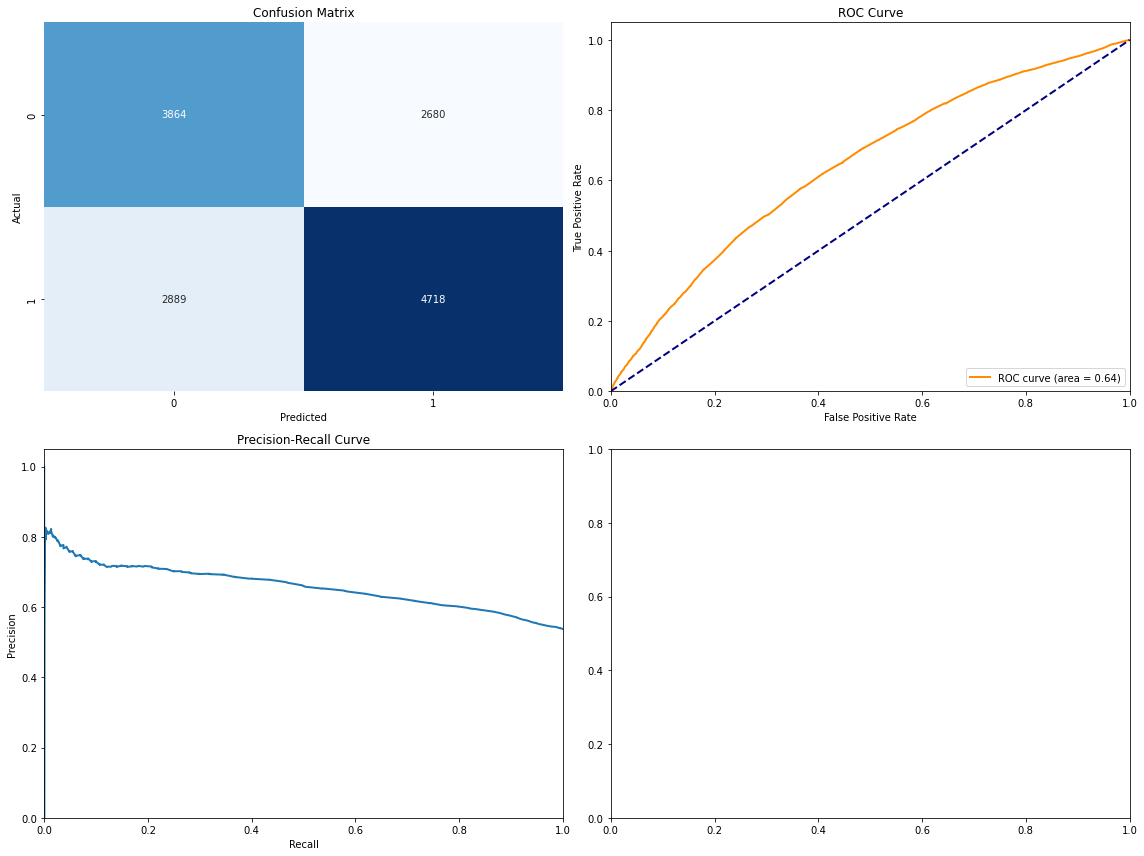

In [221]:
plot_classification_summary(rf_model_2, X_train_resampled, test_data_clean, y_train_resampled, test_targets_clean)

### Predicting on XGBoost

In [ ]:
# y_train_resampled_xgb = y_train_resampled.copy(deep=True)
# y_train_resampled_xgb[y_train_resampled_xgb == -1] = 0

# xgb_params = {
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'n_estimators': [50, 100, 200],
#     'gamma': [0, 0.1, 0.3]
# }

# xgb_clf = xgb.XGBClassifier(random_state=42)
# xgb_grid = GridSearchCV(xgb_clf, param_grid=xgb_params, cv=2, verbose=10)
# xgb_grid.fit(X_train_resampled, y_train_resampled_xgb)

# print("XGBoost: Best parameters: ", xgb_grid.best_params_)
# print("XGBoost: Best score: ", xgb_grid.best_score_)

In [222]:
y_train_resampled_xgb = y_train_resampled.copy(deep=True)
y_train_resampled_xgb[y_train_resampled_xgb == -1] = 0
# xgb_model_2 = xgb_grid.best_estimator_
xgb_model_2 = xgb.XGBClassifier(random_state=42)
train_and_evaluate_model(X_train_resampled, y_train_resampled_xgb, xgb_model_2)

0.6702363180198114

In [223]:
y_test_xgb = y_test.copy(deep=True)
y_test_xgb[y_test_xgb == -1] = 0
test_data_clean, test_targets_clean, test_preds = preprocess_and_test_model(X_test, y_test_xgb, scaler, boruta_selector, xgb_model_2)

AUC score: 0.6165776969031548


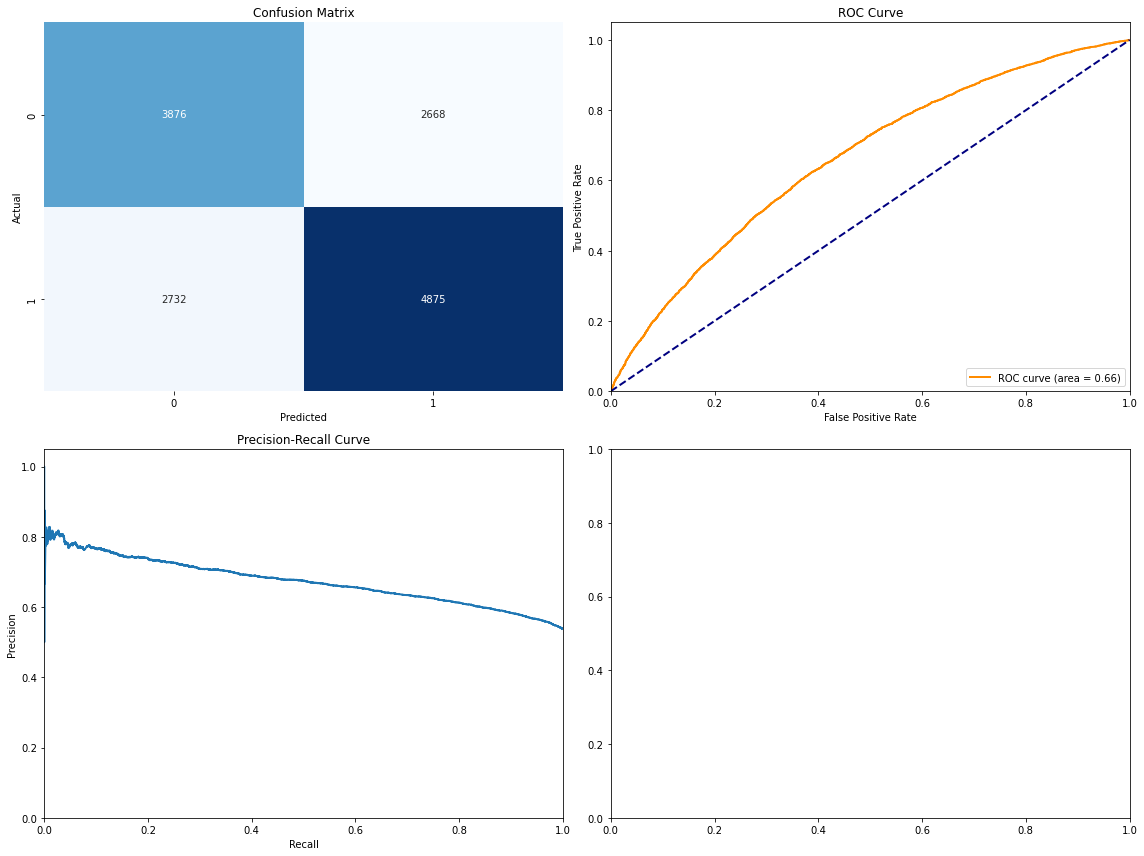

In [225]:
plot_classification_summary(xgb_model_2, X_train_resampled, test_data_clean, y_train_resampled, test_targets_clean)

# Conclusion

Based on the results obtained from the models trained on Dataset 2 and Dataset 3, it can be observed that the XGBoost and Random Forest classifiers both performed well on Dataset 2 with an ROC AUC score of 0.93 and 0.94 respectively on the training set, and an ROC AUC score of 0.77 and 0.73 respectively on the testing set. In contrast, the XGBoost and Random Forest classifiers performed poorly on Dataset 3 with an ROC AUC score of 0.67 and 0.66 respectively on the training set, and an ROC AUC score of 0.61 and 0.60 respectively on the testing set.

As a result of the lower accuracy score and low true positive rate obtained from the models trained on Dataset 3, it was decided not to use these models. The XGBoost model trained on Dataset 2, which had the best performance in both pipelines, will be used for holdout predictions.

Overall, the results suggest that the XGBoost and Random Forest classifiers are effective in predicting the target variable for Dataset 2. However, the same models are not as effective for Dataset 3, indicating that the nature and characteristics of the datasets play a crucial role in the model's performance.

# Predictions on the houldout set

The predictions were performed after running the code cells for first pipeline again to get the appropriate `feature_extractor`, `scaler` and the model.

In [227]:
# Imporing the holdout set
holdout_df = pd.read_csv('df_holdout.csv')

## Preprocessing the holdout set

Preprocessing the holdout set to remove any missing values, reduce the features to make it consistent to the training process and scaling the data

In [271]:
# Removing missing values if any
holdout_df  = holdout_df.dropna()

# Removing the columns starting with 'Info_'
filtered_holdout_df = holdout_df.filter(regex='^(?!Info_)')

filtered_holdout_df.shape

(2041, 1280)

In [272]:
filtered_holdout_df.head()

## Reducing the features and scaling the dataset
holdout_trainset = scaler.transform(filtered_holdout_df)
holdout_trainset = boruta_selector.transform(holdout_trainset)
holdout_trainset.shape

(2041, 276)

In [273]:
## Making predictions on the holdout set on my best performing model
holdout_predictions = xgb_model.predict(holdout_trainset)

## Changing the predictions of class 0 back to -1 for saving as the xgb model predicts classes from 0.
holdout_predictions[holdout_predictions == 0] = -1

# Saving the predictions in format specified and converting it to a csv
holdout_results = pd.DataFrame({
    'Info_PepID': holdout_df['Info_PepID'],
    'Info_pos': holdout_df['Info_pos'],
    'Prediction': holdout_predictions
})

holdout_results.to_csv('Tagade_Chinmay_CS4850_predictions.csv')

# References

- Ashford, J., Reis-Cunha, J., Lobo, I., Lobo, F., & Campelo, F. (2021). Organism-specific training improves performance of linear B-cell epitope prediction. Bioinformatics, 37(24), 4826-4834. https://doi.org/10.1093/bioinformatics/btab536

- Kursa, M. B., & Rudnicki, W. R. (2010). Feature selection with the Boruta package. Journal of Statistical Software, 36(11), 1-13. https://doi.org/10.18637/jss.v036.i11